In [1]:
# Unified data ingest with optional subset/caching so we can iterate quickly
import re
from pathlib import Path
import pandas as pd
import numpy as np

HERE = Path.cwd().resolve()
PROJECT_ROOT = HERE if (HERE / "data").exists() else HERE.parent
RAW_PATH = PROJECT_ROOT / "data/arrets_ben.csv"
SMALL_SAMPLE_PATH = PROJECT_ROOT / "data/oct2024.csv"
PARQUET_CACHE = PROJECT_ROOT / "arrets_ben.parquet"
USE_SMALL_SAMPLE = False   # flip to False when you want the full month
FORCE_REBUILD_PARQUET = False

def _read_full_fixed_width(path: Path) -> pd.DataFrame:
    """Read the raw fixed-width export once (≈10 min) and return a clean dataframe."""
    with path.open(encoding="utf-8-sig") as f:
        header_line = f.readline().rstrip("\n")
        dash_line = f.readline().rstrip("\n")
    colspecs = [(m.start(), m.end()) for m in re.finditer(r"-+", dash_line)]
    colspecs[-1] = (colspecs[-1][0], None)
    raw_names = [header_line[s:] if e is None else header_line[s:e] for s, e in colspecs]
    names, seen = [], {}
    for nm in map(str.strip, raw_names):
        seen[nm] = seen.get(nm, -1) + 1
        names.append(nm if seen[nm] == 0 else f"{nm}_{seen[nm]}")
    df_full = pd.read_fwf(
        path, colspecs=colspecs, names=names, skiprows=2, na_values=["NULL"], encoding="utf-8-sig"
    )
    print(f"[FWF] detected {len(names)} columns, shape={df_full.shape}")
    return df_full

if USE_SMALL_SAMPLE and SMALL_SAMPLE_PATH.exists():
    df = pd.read_csv(SMALL_SAMPLE_PATH, low_memory=False)
    print(f"Loaded subset {SMALL_SAMPLE_PATH.relative_to(PROJECT_ROOT)} -> {df.shape}")
else:
    if PARQUET_CACHE.exists() and not FORCE_REBUILD_PARQUET:
        try:
            df = pd.read_parquet(PARQUET_CACHE)
            print(f"Loaded cached parquet {PARQUET_CACHE.relative_to(PROJECT_ROOT)} -> {df.shape}")
        except Exception as exc:
            print(f"Parquet load failed ({exc}); falling back to raw file.")
            df = _read_full_fixed_width(RAW_PATH)
    else:
        df = _read_full_fixed_width(RAW_PATH)
        try:
            df.to_parquet(PARQUET_CACHE, index=False)
            print(f"Cached parquet to {PARQUET_CACHE}")
        except Exception as exc:
            print(f"Parquet export skipped: {exc}")

print(df.head(3))

[FWF] detected 73 columns, shape=(2301409, 73)
Parquet export skipped: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.
   IdCourse  IdArret  RangArretAsc  DateCourse HDepartTheo HArriveeTheo  \
0  83748979      261             1  2024-10-01    16:59:00     16:59:00   
1  83748853      261             1  2024-10-01    06:31:00     06:31:00   
2  83748927     6948             1  2024-10-01    05:07:00     05:07:00   

   DistanceTheo  TempsInterArretTheo  EcartDepart  EcartDistance  ...  \
0             0                    0           58              0  ...   
1             0             

### Build Segment

In [2]:
# =========================
# Build `seg` (prev stop -> current stop) from df
# - single-source targets:
#     link_s  := TempsInterArretRealise               (actual link runtime)
#     dwell_s := DTSortieFenetreArretReal - DTEntreeFenetreArretReal (window-based dwell)
# - punctuality signals (if present):
#     E_i, E_prev, dE := EcartDepart and its lag
# - time anchor for features:
#     link_start_time := previous stop's window-exit (fallback to ATP enter, then schedule depart)
# =========================
import numpy as np
import pandas as pd

seg_src = df.copy()

# --- 0) Parse datetimes (only if columns exist) ---
time_cols = [
    "DTDepartTheo","DTArriveeTheo",
    "DTEntreeFenetreArretReal","DTSortieFenetreArretReal",
    "DTEntreeArretAtp","DTSortieArretAtp",
    "DTMarquageArretTheo","DTMarquageArretReal",
    "HOuverturePortesReal","HFermetureportesReal"
]
for c in time_cols:
    if c in seg_src.columns:
        seg_src[c] = pd.to_datetime(seg_src[c], errors="coerce")

# --- 1) Basic casting / trimming ---
# IDs & ordering
if "RangArretAsc" in seg_src.columns:
    seg_src["RangArretAsc"] = pd.to_numeric(seg_src["RangArretAsc"], errors="coerce")
if "C_Ligne" in seg_src.columns:
    seg_src["C_Ligne"] = pd.to_numeric(seg_src["C_Ligne"], errors="coerce")

# stop codes / direction as clean strings
seg_src["CodeLong"] = seg_src.get("CodeLong", "").astype(str).str.strip()
if "C_SensAppl" in seg_src.columns:
    seg_src["C_SensAppl"] = seg_src["C_SensAppl"].astype(str).str.strip()

# distances & counts (if exist)
for c in ["DistanceInterArret","TempsInterArretRealise","EcartDepart","NbMontees","NbDescentes"]:
    if c in seg_src.columns:
        seg_src[c] = pd.to_numeric(seg_src[c], errors="coerce")

# --- 2) Sort and build previous-stop columns (within a trip/course) ---
by = ["IdCourse","RangArretAsc"] if "IdCourse" in seg_src.columns else ["C_Ligne","DateCourse","RangArretAsc"]
seg_src = seg_src.sort_values(by, kind="mergesort")

grp = seg_src.groupby("IdCourse") if "IdCourse" in seg_src.columns else seg_src.groupby(["C_Ligne","DateCourse"])

seg_src["prev_CodeLong"] = grp["CodeLong"].shift(1)

# previous-window exit (our preferred "actual depart" at upstream stop)
if {"DTEntreeFenetreArretReal","DTSortieFenetreArretReal"}.issubset(seg_src.columns):
    seg_src["prev_DT_win_out"] = grp["DTSortieFenetreArretReal"].shift(1)
    seg_src["prev_DT_win_in"]  = grp["DTEntreeFenetreArretReal"].shift(1)
else:
    seg_src["prev_DT_win_out"] = np.nan
    seg_src["prev_DT_win_in"]  = np.nan

# fallbacks if window missing: ATP enter, then scheduled depart
seg_src["prev_DT_atp_in"]   = grp["DTEntreeArretAtp"].shift(1) if "DTEntreeArretAtp" in seg_src.columns else np.nan
seg_src["prev_DT_sched_dep"]= grp["DTDepartTheo"].shift(1)     if "DTDepartTheo" in seg_src.columns else np.nan

# upstream demand / punctuality
for c in ["NbMontees","NbDescentes","EcartDepart"]:
    if c in seg_src.columns:
        seg_src[f"prev_{c}"] = grp[c].shift(1)

# --- 3) Keep only rows that have a previous stop (i.e., valid link) ---
seg = seg_src.dropna(subset=["prev_CodeLong"]).copy()
seg["from_stop"] = seg["prev_CodeLong"].astype(str).str.strip()
seg["to_stop"]   = seg["CodeLong"].astype(str).str.strip()
seg["SegmentKey"] = seg["from_stop"] + "→" + seg["to_stop"]

# --- 4) Targets from single sources ---
# 4a) Actual link runtime: Realise (single source; no cross-source mixing)
seg["link_s"] = seg.get("TempsInterArretRealise")
seg.loc[(seg["link_s"]<=0) | (seg["link_s"]>1800), "link_s"] = np.nan  # basic QC (0/neg, >30min)

# 4b) Dwell time from window timestamps (single source)
if {"DTEntreeFenetreArretReal","DTSortieFenetreArretReal"}.issubset(seg.columns):
    seg["dwell_s"] = (seg["DTSortieFenetreArretReal"] - seg["DTEntreeFenetreArretReal"]).dt.total_seconds()
    seg.loc[(seg["dwell_s"]<0) | (seg["dwell_s"]>900), "dwell_s"] = np.nan  # QC: <0 or >15min
else:
    seg["dwell_s"] = np.nan

# 4c) Punctuality signals (if present)
seg["E_i"]    = pd.to_numeric(seg.get("EcartDepart"), errors="coerce")
seg["E_prev"] = pd.to_numeric(seg.get("prev_EcartDepart"), errors="coerce")
seg["dE"]     = seg["E_i"] - seg["E_prev"]

# --- 5) Upstream dwell used as a feature (window-based) ---
seg["dwell_prev_s"] = (seg["prev_DT_win_out"] - seg["prev_DT_win_in"]).dt.total_seconds()
seg.loc[(seg["dwell_prev_s"]<0) | (seg["dwell_prev_s"]>900), "dwell_prev_s"] = np.nan

# --- 6) Distance feature (static meta; keep raw to avoid mixing assumptions) ---
seg["distance_m"] = pd.to_numeric(seg.get("DistanceInterArret"), errors="coerce")
seg.loc[seg["distance_m"]<0, "distance_m"] = np.nan

# --- 7) Time anchor for features: previous stop's window-exit (fallbacks) ---
seg["link_start_time"] = seg["prev_DT_win_out"]
seg.loc[seg["link_start_time"].isna(), "link_start_time"] = seg["prev_DT_atp_in"]
seg.loc[seg["link_start_time"].isna(), "link_start_time"] = seg["prev_DT_sched_dep"]

# Drop rows without any anchor time
seg = seg[pd.notna(seg["link_start_time"])].copy()

# Calendar & cyclical features
seg["hour"] = seg["link_start_time"].dt.hour
seg["dow"]  = seg["link_start_time"].dt.dayofweek   # 0=Mon .. 6=Sun
seg["is_weekend"] = seg["dow"].isin([5,6]).astype(int)
seg["hour_sin"] = np.sin(2*np.pi*seg["hour"]/24.0)
seg["hour_cos"] = np.cos(2*np.pi*seg["hour"]/24.0)
seg["period168"] = seg["dow"]*24 + seg["hour"]      # 0..167

# Optional coarse label (handy for plots)
def assign_period(dt):
    h, d = dt.hour, dt.dayofweek
    if d==5: return "Sat"
    if d==6: return "Sun"
    if 7<=h<9:   return "AM"
    if 9<=h<16:  return "Day"
    if 16<=h<19: return "PM"
    if 19<=h<23: return "Eve"
    return "Other"
seg["period"] = seg["link_start_time"].map(assign_period)

# --- 8) IDs for grouping/filters ---
seg["line"] = seg.get("C_Ligne").astype("Int64").astype(str) if "C_Ligne" in seg.columns else "NA"
seg["dir"]  = seg.get("C_SensAppl", "NA").astype(str)

# demand features from upstream stop (if present)
seg["board_prev"]  = pd.to_numeric(seg.get("prev_NbMontees"),   errors="coerce")
seg["alight_prev"] = pd.to_numeric(seg.get("prev_NbDescentes"), errors="coerce")

# --- 9) Feature list for GBM (E/ΔE) ---
feat_cols = [
    "distance_m","dwell_prev_s","E_prev",
    "board_prev","alight_prev",
    "hour_sin","hour_cos","dow","is_weekend",
    "from_stop","to_stop","line","dir"
]

print(f"[seg] rows: {len(seg):,}")
print("Targets available:",
      f"link_s={seg['link_s'].notna().mean():.2%}",
      f"dwell_s={seg['dwell_s'].notna().mean():.2%}",
      f"E_i={seg['E_i'].notna().mean():.2%}",
      f"E_prev={seg['E_prev'].notna().mean():.2%}",
      f"dE={seg['dE'].notna().mean():.2%}")
print("Feature columns:", feat_cols)

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_87892/3484066424.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  seg_src[c] = pd.to_datetime(seg_src[c], errors="coerce")
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_87892/3484066424.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  seg_src[c] = pd.to_datetime(seg_src[c], errors="coerce")
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_87892/3484066424.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  seg_src[c] = pd.to_datetime(seg_src[c], errors="coerce")


[seg] rows: 2,173,850
Targets available: link_s=99.99% dwell_s=99.99% E_i=100.00% E_prev=100.00% dE=100.00%
Feature columns: ['distance_m', 'dwell_prev_s', 'E_prev', 'board_prev', 'alight_prev', 'hour_sin', 'hour_cos', 'dow', 'is_weekend', 'from_stop', 'to_stop', 'line', 'dir']


In [3]:
# Merge static stop metadata (X/Y, zone) as external features
stops_path = PROJECT_ROOT / "data/stops_df.csv"
stops_meta = pd.read_csv(stops_path)
stops_meta = stops_meta.rename(columns={
    "MNLP":"stop_code","LIBP":"stop_name","X":"stop_x","Y":"stop_y",
    "ZONE":"zone_code","LIBTTS":"tts_label"
})
stops_meta = stops_meta.drop_duplicates("stop_code")[["stop_code","stop_name","stop_x","stop_y","zone_code"]]

from_meta = stops_meta.add_prefix("from_")
to_meta = stops_meta.add_prefix("to_")
seg = seg.merge(from_meta, left_on="from_stop", right_on="from_stop_code", how="left")
seg = seg.merge(to_meta, left_on="to_stop", right_on="to_stop_code", how="left")
seg = seg.drop(columns=["from_stop_code","to_stop_code"], errors="ignore")

seg["geom_dx"] = seg["to_stop_x"] - seg["from_stop_x"]
seg["geom_dy"] = seg["to_stop_y"] - seg["from_stop_y"]
seg["straight_dist_geom_m"] = np.hypot(seg["geom_dx"], seg["geom_dy"])
seg["bearing_rad"] = np.arctan2(seg["geom_dy"], seg["geom_dx"])
seg["bearing_sin"] = np.sin(seg["bearing_rad"])
seg["bearing_cos"] = np.cos(seg["bearing_rad"])

seg["zone_pair"] = seg["from_zone_code"].astype(str) + ">" + seg["to_zone_code"].astype(str)
seg["zone_changed"] = (seg["from_zone_code"] != seg["to_zone_code"]).astype(int)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_reliability_metrics(
    seg,
    line=None, dir_=None,
    per100m=False,           # if True, use sec/100m
    min_n=5,                # require at least min_n samples per cell
    q_high=95                # RBI percentile (e.g., 95)
):
    s = seg.copy()

    # optional filters
    if line is not None:
        s = s[s["line"].astype(str) == str(line)]
    if dir_ is not None:
        s = s[s["dir"].astype(str) == str(dir_)]

    # clean
    s = s[pd.to_numeric(s["link_s"], errors="coerce") > 0].copy()
    s["period168"] = s["period168"].astype(int)

    # value to aggregate
    if per100m:
        s = s[pd.to_numeric(s["distance_m"], errors="coerce") > 0].copy()
        s["val"] = s["link_s"] / (s["distance_m"] / 100.0)   # sec per 100m
        val_unit = "sec/100m"
    else:
        s["val"] = s["link_s"]
        val_unit = "sec"

    def _agg_group(g):
        x = g["val"].to_numpy(float)
        n = x.size
        if n == 0:
            return pd.Series({"n": 0, "mu": np.nan, "sigma": np.nan,
                              "p_high": np.nan, "cv": np.nan, "rbi": np.nan, "rf": np.nan})
        mu = float(np.mean(x))
        sigma = float(np.std(x, ddof=1)) if n > 1 else 0.0
        p_high = float(np.nanpercentile(x, q_high)) if np.isfinite(x).any() else np.nan

        # Reliability metrics
        cv = (sigma / mu) if mu > 0 else np.nan                           # C_v = sigma / mu
        rbi = ((p_high - mu) / mu) if (mu > 0 and np.isfinite(p_high)) else np.nan  # RBI
        if mu > 0:
            tol = 0.10 * mu                                               # ±10% of mean
            rf = float(((x >= mu - tol) & (x <= mu + tol)).mean())        # RF in [0,1]
        else:
            rf = np.nan

        return pd.Series({"n": n, "mu": mu, "sigma": sigma,
                          "p_high": p_high, "cv": cv, "rbi": rbi, "rf": rf})

    agg = (s.groupby(["SegmentKey", "period168"], observed=True)
             .apply(_agg_group)
             .reset_index())

    # mask cells with too few samples
    for col in ["mu","sigma","p_high","cv","rbi","rf"]:
        agg.loc[agg["n"] < min_n, col] = np.nan

    agg.attrs["val_unit"] = val_unit
    agg.attrs["q_high"] = q_high
    return agg

def build_metric_mats(agg, ordered_keys=None):
    """
    Returns dict of pivoted matrices (index=SegmentKey, columns=period168).
    """
    mats = {}
    metrics = ["n","mu","cv","rbi","rf"]
    for m in metrics:
        pv = agg.pivot(index="SegmentKey", columns="period168", values=m)
        # fix columns 0..167
        pv = pv.reindex(columns=range(168))
        mats[m] = pv

    # enforce row order if provided (e.g., your top-pattern ordered_keys)
    if ordered_keys is not None:
        for k in mats:
            mats[k] = mats[k].reindex(index=ordered_keys)
    return mats


def _imshow168(ax, M, title, cbar_label, percent=False, vmin=None, vmax=None):
    arr = M.to_numpy()
    # robust color limits if not given
    if vmin is None or vmax is None:
        vmin = np.nanpercentile(arr, 1) if vmin is None else vmin
        vmax = np.nanpercentile(arr, 99) if vmax is None else vmax

    im = ax.imshow(arr, aspect="auto", origin="upper",
                   interpolation="nearest", vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)
    ax.set_xlabel("period168 (Mon00=0 … Sun23=167)")
    ax.set_ylabel("segments (top → bottom)")
    ax.set_title(title)
    # day separators
    for d in range(1,7):
        ax.axvline(d*24-0.5, color="k", lw=1, alpha=0.25)
    # y ticks (sparser if many rows)
    if len(M.index) <= 40:
        ax.set_yticks(range(len(M.index)))
        ax.set_yticklabels(M.index, fontsize=8)
    else:
        ax.set_yticks([])

def plot_reliability_heatmaps(mats, line=None, dir_=None, val_unit="sec", q_high=95, figsize=(18,6)):
    ttl_pfx = f"Line {line} | dir={dir_} — " if (line is not None or dir_ is not None) else ""
    fig, axs = plt.subplots(1, 3, figsize=figsize, constrained_layout=True)

    _imshow168(
        axs[0], mats["cv"],
        f"{ttl_pfx}Coefficient of Variation (σ/μ)",
        "Cᵥ (dimensionless)"
    )
    _imshow168(
        axs[1], mats["rbi"],
        f"{ttl_pfx}Reliability Buffer Index (p{q_high}−μ)/μ",
        "RBI (fraction)"
    )
    _imshow168(
        axs[2], mats["rf"],
        f"{ttl_pfx}Reliability Factor: % within ±10% of μ",
        "RF (0–1)", vmin=0.0, vmax=1.0
    )
    plt.show()

In [13]:
def top_unreliable_cells(agg, by="rbi", top=20):
    """Return the top `top` (SegmentKey, period168) cells with highest selected metric."""
    df = agg.dropna(subset=[by]).copy()
    return (df.sort_values(by, ascending=False)
              [["SegmentKey","period168","n","mu","cv","rbi","rf"]]
              .head(top))

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_87892/1739818825.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_agg_group)


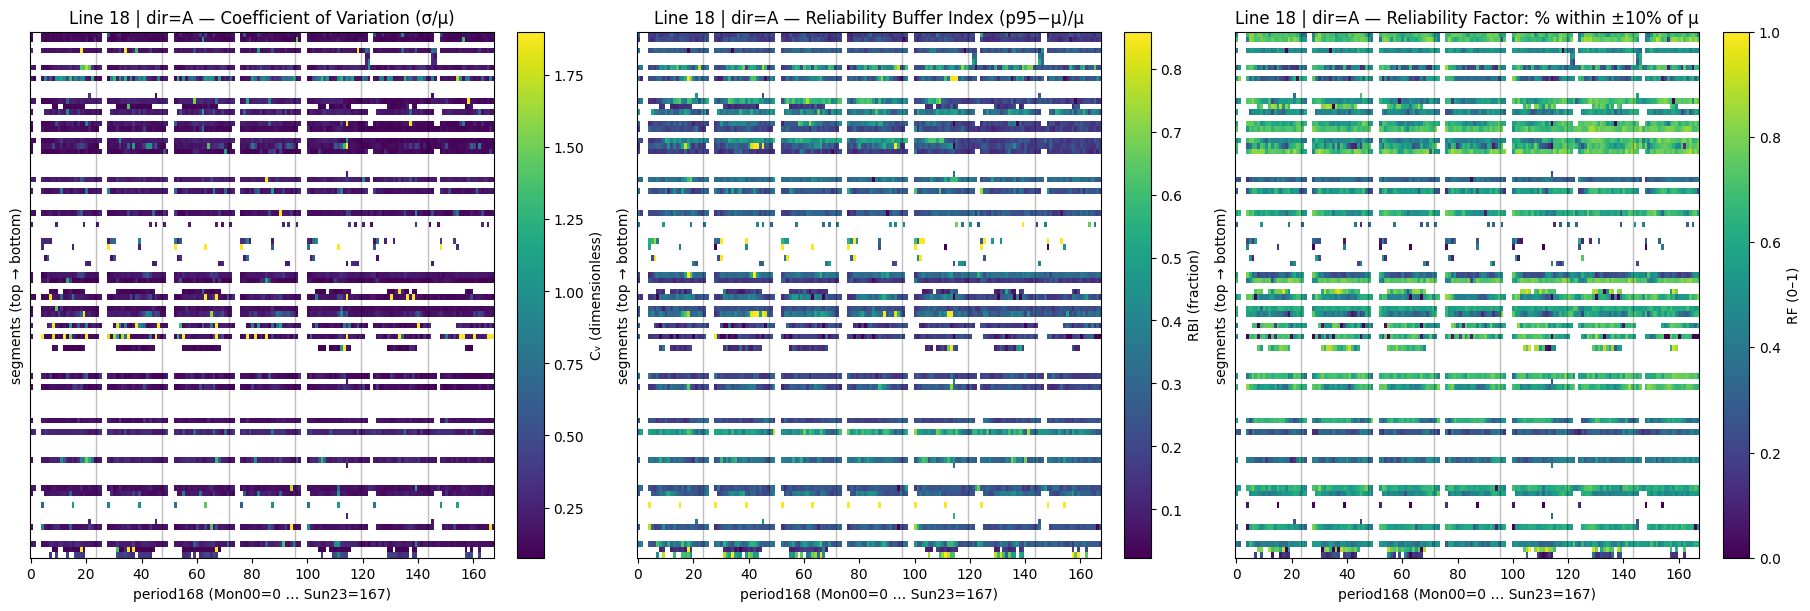

         SegmentKey  period168      n          mu        cv       rbi  \
2977    DB00→STAL03         76   36.0  252.958542  2.395134  5.819299   
2974    DB00→STAL03         63   22.0  281.258540  2.613794  5.613133   
2966    DB00→STAL03         52   42.0  236.475333  2.364351  3.836908   
6146  STAL03→CRGE00         63   20.0   79.119636  1.441707  3.081785   
672   BAIR01→COUT03         18  175.0   46.624450  0.931007  2.145334   
762   BAIR01→COUT03        115  113.0   39.700928  0.731695  1.900474   
2986    DB00→STAL03        100   36.0   91.574074  0.771151  1.899682   
2908    DB00→BHET01         30   40.0   62.899899  0.704983  1.896383   
4062  MYRN00→HTOU00         42  195.0   35.576922  0.940087  1.894450   
4063  MYRN00→HTOU00         43  177.0   29.725461  0.822815  1.861574   
2925    DB00→BHET01         78   40.0   60.853405  0.899873  1.740524   
2938    DB00→BHET01        125   28.0   58.307788  0.732128  1.730326   
6171  STAL03→CRGE00        148   31.0  137.876274  

In [14]:
# 1) compute metrics for one line/dir, using seconds per 100m (robust across segments)
agg18A = compute_reliability_metrics(seg, line=18, dir_="A", per100m=True, min_n=15, q_high=95)

# (Optional) keep your route order:
# ordered_keys = order_keys_by_top_pattern(seg_pat_oct, line=18, dir_="A")
ordered_keys = None  # or a list of "A→B" strings

# 2) matrices & heatmaps
mats18A = build_metric_mats(agg18A, ordered_keys=ordered_keys)
plot_reliability_heatmaps(mats18A, line=18, dir_="A",
                          val_unit=agg18A.attrs["val_unit"],
                          q_high=agg18A.attrs["q_high"])

# 3) a quick “worst cells” table for the appendix
tbl_worst = top_unreliable_cells(agg18A, by="rbi", top=15)
print(tbl_worst)

In [49]:
# Assumes you already have `seg` with:
# - line, from_stop, to_stop
# - link_start_time (datetime)
# - TempsInterArretRealise (actual link runtime)
# - DTEntreeFenetreArretReal, DTSortieFenetreArretReal (window timestamps)

# 1) segment key (include line to avoid cross-line collisions)
seg = seg.copy()
seg["seg3"] = seg["line"].astype(str) + "|" + seg["from_stop"] + "→" + seg["to_stop"]

# 2) actual link runtime (single source: Realise)
seg["link_s"] = pd.to_numeric(seg.get("TempsInterArretRealise"), errors="coerce")

# 3) dwell (single source: window)
if {"DTEntreeFenetreArretReal","DTSortieFenetreArretReal"}.issubset(seg.columns):
    seg["dwell_s"] = (
        seg["DTSortieFenetreArretReal"] - seg["DTEntreeFenetreArretReal"]
    ).dt.total_seconds()
else:
    seg["dwell_s"] = np.nan

# 4) basic QC (leave NaN if missing; remove impossible/outlier tails conservatively)
seg.loc[seg["link_s"]<=0, "link_s"] = np.nan
seg.loc[seg["link_s"]>1800, "link_s"] = np.nan  # 30 min hard cap (tune)
seg.loc[seg["dwell_s"]<0, "dwell_s"] = np.nan
seg.loc[seg["dwell_s"]>900, "dwell_s"] = np.nan  # 15 min hard cap (tune)

# 5) time bins: hour-of-day × day-of-week -> 168 buckets
ts = seg["link_start_time"]
seg["dow"]   = ts.dt.dayofweek      # 0=Mon..6=Sun
seg["hour"]  = ts.dt.hour           # 0..23
seg["period168"] = seg["dow"]*24 + seg["hour"]  # 0..167

In [50]:
def attach_smooth_baseline(train_df, test_df, target="link_s", q=0.5, bandwidth=1.4, tau=25.0):
    fine = smooth_quantile_over_168(train_df, target=target, by=("SegmentKey",), q=q, bandwidth=bandwidth)
    parent = (train_df.dropna(subset=[target])
              .groupby("SegmentKey")[target]
              .median().rename("q_parent").reset_index())
    lookup = hier_shrink(fine, parent, tau=tau).set_index(["SegmentKey","period168"])
    gq = float(train_df[target].dropna().quantile(q)) if train_df[target].notna().any() else 0.0
    col = f"base_{target.replace('_s','')}_p{int(q*100)}_smooth"
    for frame in (train_df, test_df):
        key = pd.MultiIndex.from_arrays([frame["SegmentKey"], frame["period168"].astype(int)])
        vals = lookup.reindex(key)["q_final"].to_numpy()
        frame[col] = pd.Series(vals, index=frame.index).fillna(gq)
    return col

b_link50, _, _, _ = make_empirical_baseline(train, test, target="link_s", q=0.50)
b_link85, _, _, _ = make_empirical_baseline(train, test, target="link_s", q=0.85)
test["base_link_p50_emp"] = b_link50
test["base_link_p85_emp"] = b_link85
col_p50 = attach_smooth_baseline(train, test, target="link_s", q=0.50, bandwidth=1.4, tau=20.0)
col_p85 = attach_smooth_baseline(train, test, target="link_s", q=0.85, bandwidth=1.4, tau=20.0)

print("=== Link_s baselines ===")
print("MAE vs empirical p50:", mae(test["link_s"], test["base_link_p50_emp"]))
print("MAE vs smoothed p50:", mae(test["link_s"], test[col_p50]))
print("Cov@p85 empirical :", coverage(test["link_s"], test["base_link_p85_emp"]))
print("Cov@p85 smooth    :", coverage(test["link_s"], test[col_p85]))

=== Link_s baselines ===
MAE vs empirical p50: 15.49367088607595
MAE vs smoothed p50: 15.09578103296885
Cov@p85 empirical : 0.7341772151898734
Cov@p85 smooth    : 0.759493670886076


In [9]:
# TRR-style reliability indicators (Hu & Shalaby, 2017) at Segment×period168
OTP_TOL_S = 60  # ±60s arrival window for on-time performance
RF_TOL = 0.10   # ±10% of mean travel time
SLOW_SPEED_KMH = 15

def _trr_metrics_block(g):
    vals = g["link_s"].dropna().to_numpy()
    if len(vals) == 0:
        return pd.Series({c: np.nan for c in ["n","mean","median","p95","buffer_index","reliability_buffer_index","cv_tt","otp","wdi","rf10","slow_rate"]})
    mean_tt = float(np.nanmean(vals))
    median_tt = float(np.nanmedian(vals))
    p95 = float(np.nanpercentile(vals, 95))
    slow_rate = float(np.mean(g.get("slow_flag_15k", 0)))
    bi = (p95 - mean_tt) / mean_tt if mean_tt > 0 else np.nan
    rbi = (p95 - median_tt) / median_tt if median_tt > 0 else np.nan
    cv_tt = float(np.nanstd(vals) / mean_tt) if mean_tt > 0 else np.nan
    if g["link_delta_sched_s"].notna().any():
        otp = float(np.mean(np.abs(g["link_delta_sched_s"]) <= OTP_TOL_S))
    else:
        otp = np.nan
    rf = float(np.mean(np.abs(g["link_s"] - mean_tt) <= RF_TOL * mean_tt)) if mean_tt > 0 else np.nan
    sched_headway = float(np.nanmedian(g["sched_headway_s"])) if g["sched_headway_s"].notna().any() else np.nan
    if np.isfinite(sched_headway) and sched_headway > 0 and g["sched_link_s"].notna().any():
        delay_plus = np.maximum(g["link_s"] - g["sched_link_s"], 0) / 60.0
        valid = delay_plus[np.isfinite(delay_plus)]
        if len(valid):
            buckets = np.floor(valid)
            uniq, counts = np.unique(buckets, return_counts=True)
            pk = counts / counts.sum()
            wdi = float(np.sum(pk * uniq) / (sched_headway / 60.0))
        else:
            wdi = np.nan
    else:
        wdi = np.nan
    return pd.Series({
        "n": len(vals),
        "mean": mean_tt,
        "median": median_tt,
        "p95": p95,
        "buffer_index": bi,
        "reliability_buffer_index": rbi,
        "cv_tt": cv_tt,
        "otp": otp,
        "wdi": wdi,
        "rf10": rf,
        "slow_rate": slow_rate
    })

def compute_trr_table(df):
    return (df.groupby(["SegmentKey","period168"], observed=True)
              .apply(_trr_metrics_block, include_groups=False).reset_index())

trr_train = compute_trr_table(train)
trr_test = compute_trr_table(test)
print(trr_train.describe().T.loc[["buffer_index","reliability_buffer_index","cv_tt","otp","wdi","rf10","slow_rate"]])

                            count      mean       std       min       25%  \
buffer_index              16056.0  0.306336  0.233591 -0.004664  0.169895   
reliability_buffer_index  16056.0  0.373499  0.609810  0.000000  0.175532   
cv_tt                     16056.0  0.193559  0.132119  0.000000  0.116245   
otp                       16048.0  0.913429  0.176208  0.000000  0.916667   
wdi                       12038.0  0.146201  0.751834  0.000000  0.000000   
rf10                      16056.0  0.490995  0.233393  0.000000  0.321429   
slow_rate                 16056.0  0.396451  0.384454  0.000000  0.000000   

                               50%       75%        max  
buffer_index              0.255104  0.377897   4.200000  
reliability_buffer_index  0.279454  0.440684  45.225000  
cv_tt                     0.168225  0.234433   2.474841  
otp                       1.000000  1.000000   1.000000  
wdi                       0.000000  0.062500  24.705882  
rf10                      0.500000 

In [10]:
# Historical segment×period indicators for modeling (slow rate, dwell, headway)
train = train.copy()
test = test.copy()
train["slow_history_flag"] = (train["speed_kmh"] < SLOW_SPEED_KMH).astype(float)
train["long_dwell_flag"] = (train["dwell_prev_s"] > 60).astype(float)
hist_rates = (train.groupby(["SegmentKey","period168"], observed=True)
              .agg(slow_rate_hist=("slow_history_flag","mean"),
                   long_dwell_rate_hist=("long_dwell_flag","mean"),
                   median_headway_hist=("headway_s","median"),
                   median_distance_hist=("distance_m","median"))
              .reset_index())

train = train.merge(hist_rates, on=["SegmentKey","period168"], how="left")
test = test.merge(hist_rates, on=["SegmentKey","period168"], how="left", suffixes=("","_hist"))
for col in ["slow_rate_hist","long_dwell_rate_hist","median_headway_hist","median_distance_hist"]:
    if f"{col}_hist" in test.columns:
        test[col] = test[col].fillna(test[f"{col}_hist"])
        test = test.drop(columns=[f"{col}_hist"])
    global_val = float(hist_rates[col].mean()) if col in hist_rates else np.nan
    train[col] = train[col].fillna(global_val)
    test[col] = test[col].fillna(global_val)

In [17]:
# Residual per 100m target for tree-based residual model
for frame in (train, test):
    dist = frame["distance_m"].where(frame["distance_m"] > 0)
    frame["y_res_100m"] = (frame["link_s"] - frame["base_link_p50_smooth"]) / (dist / 100.0)

In [40]:
from sklearn.preprocessing import StandardScaler
from typing import Sequence, Optional

class SegmentPDTT:
    def __init__(self, feature_cols: Sequence[str], target_col: str = "link_s",
                 k_neighbors: int = 50, min_seg_samples: int = 20, min_line_samples: int = 40,
                 feature_weights: Optional[dict] = None, random_state: int = 13):
        self.feature_cols = list(feature_cols)
        self.target_col = target_col
        self.k_neighbors = k_neighbors
        self.min_seg_samples = min_seg_samples
        self.min_line_samples = min_line_samples
        self.feature_weights = feature_weights or {}
        self.random_state = np.random.RandomState(random_state)
        self.scaler = None
        self.train_X = None
        self.train_y = None
        self.train_meta = None
        self.train_index = None
        self.feature_medians = None
        self.weight_vec = None
        self.idx_seg_period = {}
        self.idx_seg = {}
        self.idx_line_period = {}
        self.idx_line = {}
        self.global_quantiles = {}
        self.global_mean = np.nan

    def _weight_series(self):
        weight = pd.Series(1.0, index=self.feature_cols)
        for col, w in self.feature_weights.items():
            if col in weight.index:
                weight.loc[col] = float(w)
        return weight

    def fit(self, df: pd.DataFrame):
        cols_needed = set(self.feature_cols + [self.target_col, "SegmentKey", "period168", "line", "dir"])
        missing = cols_needed - set(df.columns)
        if missing:
            raise ValueError(f"Missing columns for PDTT: {missing}")
        base = df.dropna(subset=[self.target_col]).copy().reset_index(drop=True)
        if base.empty:
            raise ValueError("No training rows with target for PDTT")
        self.feature_medians = base[self.feature_cols].median().fillna(0.0)
        self.weight_vec = self._weight_series().reindex(self.feature_cols).fillna(1.0)
        feats = base[self.feature_cols].fillna(self.feature_medians) * self.weight_vec
        self.scaler = StandardScaler().fit(feats)
        self.train_X = self.scaler.transform(feats)
        self.train_y = base[self.target_col].to_numpy(dtype=float)
        self.train_meta = base[["SegmentKey","period168","line","dir"]].reset_index(drop=True)
        self.train_index = base.index.to_numpy()
        self.idx_seg_period = {k: np.fromiter(v, dtype=int) for k, v in base.groupby(["SegmentKey","period168"]).indices.items()}
        self.idx_seg = {k: np.fromiter(v, dtype=int) for k, v in base.groupby(["SegmentKey"]).indices.items()}
        self.idx_line_period = {k: np.fromiter(v, dtype=int) for k, v in base.groupby(["line","dir","period168"]).indices.items()}
        self.idx_line = {k: np.fromiter(v, dtype=int) for k, v in base.groupby(["line","dir"]).indices.items()}
        self.global_quantiles = {
            0.5: float(np.nanquantile(self.train_y, 0.5)),
            0.85: float(np.nanquantile(self.train_y, 0.85)),
            0.95: float(np.nanquantile(self.train_y, 0.95))
        }
        self.global_mean = float(np.nanmean(self.train_y))
        return self

    def _select_pool(self, row):
        key = (row["SegmentKey"], row["period168"])
        idx = self.idx_seg_period.get(key, np.array([], dtype=int))
        if len(idx) >= self.min_seg_samples:
            return idx, 0
        idx = self.idx_seg.get(row["SegmentKey"], np.array([], dtype=int))
        if len(idx) >= self.min_seg_samples:
            return idx, 1
        key = (row["line"], row["dir"], row["period168"])
        idx = self.idx_line_period.get(key, np.array([], dtype=int))
        if len(idx) >= self.min_line_samples:
            return idx, 2
        key = (row["line"], row["dir"])
        idx = self.idx_line.get(key, np.array([], dtype=int))
        if len(idx) >= self.min_line_samples:
            return idx, 3
        return np.arange(len(self.train_y)), 4

    def _neighbor_indices(self, pool_idx, row_vec):
        pool_X = self.train_X[pool_idx]
        diff = pool_X - row_vec
        dist = np.einsum("ij,ij->i", diff, diff)
        order = np.argsort(dist)
        k = min(self.k_neighbors, len(order))
        return pool_idx[order[:k]]

    @staticmethod
    def _params_from_quantiles(vals):
        vals = np.asarray(vals)
        vals = vals[np.isfinite(vals) & (vals > 0)]
        if vals.size < 5:
            return np.nan, np.nan
        q50, q85 = np.quantile(vals, [0.50, 0.85])
        if not np.isfinite(q50) or not np.isfinite(q85) or q50 <= 0 or q85 <= 0:
            return np.nan, np.nan
        p1, p2 = 0.50, 0.85
        log_term = np.log((1/p1 - 1) / (1/p2 - 1))
        if log_term == 0:
            return np.nan, np.nan
        beta = np.log(q85 / q50) / log_term
        if not np.isfinite(beta) or beta <= 0:
            return np.nan, np.nan
        alpha = q50 * np.power(1/p1 - 1, 1/beta)
        if not np.isfinite(alpha) or alpha <= 0:
            return np.nan, np.nan
        return float(alpha), float(beta)

    @staticmethod
    def _loglogistic_quantile(alpha: float, beta: float, p):
        alpha = float(alpha)
        beta = float(beta)
        p = np.asarray(p, dtype=float)
        out = np.full_like(p, np.nan, dtype=float)
        if not np.isfinite(alpha) or not np.isfinite(beta) or alpha <= 0 or beta <= 0:
            return out if out.ndim else float('nan')
        valid = (p > 0) & (p < 1) & np.isfinite(p)
        out[valid] = alpha / np.power(1/p[valid] - 1, 1/beta)
        return out if out.ndim else float(out)

    def predict(self, df: pd.DataFrame) -> pd.DataFrame:
        if self.scaler is None:
            raise RuntimeError("SegmentPDTT must be fit before predict")
        results = []
        feat_df = df[self.feature_cols].copy()
        feat_df = feat_df.fillna(self.feature_medians)
        feat_df = feat_df * self.weight_vec
        Xq = self.scaler.transform(feat_df)
        meta = df.reset_index(drop=True)[["SegmentKey","period168","line","dir"]]
        for idx in range(len(df)):
            row = meta.iloc[idx]
            pool_idx, pool_level = self._select_pool(row)
            neighbor_idx = self._neighbor_indices(pool_idx, Xq[idx]) if len(pool_idx) else np.array([], dtype=int)
            vals = self.train_y[neighbor_idx] if len(neighbor_idx) else np.array([], dtype=float)
            if len(vals) == 0:
                p50 = self.global_quantiles[0.5]
                p85 = self.global_quantiles[0.85]
                p95 = self.global_quantiles[0.95]
                mean = self.global_mean
                alpha = beta = np.nan
                n_use = 0
            else:
                vals = np.clip(vals, 0, 1800)
                p50, p85, p95 = np.quantile(vals, [0.50, 0.85, 0.95])
                mean = float(np.nanmean(vals))
                alpha, beta = self._params_from_quantiles(vals)
                n_use = len(vals)
            results.append({
                "pdtt_alpha": alpha,
                "pdtt_beta": beta,
                "pdtt_p50": float(p50),
                "pdtt_p85": float(p85),
                "pdtt_p95": float(p95),
                "pdtt_mean": float(mean),
                "pdtt_n_neighbors": int(n_use),
                "pdtt_pool_level": pool_level
            })
        return pd.DataFrame(results, index=df.index)

    def sample(self, alpha, beta, size=100):
        if not np.isfinite(alpha) or not np.isfinite(beta) or alpha <= 0 or beta <= 0:
            return np.full(size, np.nan)
        u = self.random_state.uniform(size=size)
        draws = alpha / np.power(1 / u - 1, 1 / beta)
        return np.clip(draws, 0, 1800)

In [41]:
# Train PDTT on train window and score test
PDTT_COLS = ["pdtt_alpha","pdtt_beta","pdtt_p50","pdtt_p85","pdtt_p95","pdtt_mean","pdtt_n_neighbors","pdtt_pool_level"]
for frame in (train, test):
    frame.drop(columns=PDTT_COLS, inplace=True, errors="ignore")
pdtt_model = SegmentPDTT(
    PDTT_FEATURES,
    target_col="link_s",
    k_neighbors=50,
    min_seg_samples=20,
    min_line_samples=40,
    feature_weights={
        "headway_s":1.5,
        "sched_headway_s":1.5,
        "minute_sin":1.2,
        "minute_cos":1.2,
        "base_link_p50_smooth":2.0
    }
)
pdtt_model.fit(train)
train = train.join(pdtt_model.predict(train))
test = test.join(pdtt_model.predict(test))

def pinball_loss(y, qhat, alpha):
    m = np.isfinite(y) & np.isfinite(qhat)
    if not m.any():
        return np.nan
    err = y[m] - qhat[m]
    return float(np.mean(np.maximum(alpha*err, (alpha-1)*err)))

mae_emp = mae(test["link_s"], test["base_link_p50_emp"])
mae_smooth = mae(test["link_s"], test["base_link_p50_smooth"]) if "base_link_p50_smooth" in test else np.nan
mae_pdtt = mae(test["link_s"], test["pdtt_p50"])
pin_pdtt = pinball_loss(test["link_s"], test["pdtt_p85"], 0.85)
cov_pdtt = coverage(test["link_s"], test["pdtt_p85"])
mae_pdtt_per100 = mae(test["link_s_per100m"], test["pdtt_p50"] / (test["distance_m"]/100.0))

print(f"MAE empirical vs link_s     : {mae_emp:8.2f} s")
print(f"MAE smoothed baseline        : {mae_smooth:8.2f} s")
print(f"MAE PDTT (TRC)               : {mae_pdtt:8.2f} s")
print(f"MAE PDTT per 100m            : {mae_pdtt_per100:8.3f} s/100m")
print(f"Pinball(0.85) PDTT           : {pin_pdtt:8.2f}")
print(f"Coverage @0.85 PDTT          : {cov_pdtt:8.3f}")
print(test["pdtt_pool_level"].value_counts(normalize=True))

test["pdtt_buffer_index"] = (test["pdtt_p95"] - test["pdtt_mean"]) / test["pdtt_mean"]
test["pdtt_reliability_buffer_index"] = (test["pdtt_p95"] - test["pdtt_p50"]) / test["pdtt_p50"]

MAE empirical vs link_s     :    15.49 s
MAE smoothed baseline        :    15.10 s
MAE PDTT (TRC)               :    15.33 s
MAE PDTT per 100m            :    3.404 s/100m
Pinball(0.85) PDTT           :     6.23
Coverage @0.85 PDTT          :    0.772
pdtt_pool_level
1    0.860759
0    0.139241
Name: proportion, dtype: float64


In [42]:
# Gradient-boosted residual model (per 100m)
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

GBM_FEATURES = [
    "minute_sin","minute_cos","week_sin","week_cos","is_weekend","is_peak","is_night",
    "headway_s","sched_headway_s","distance_m","straight_dist_geom_m",
    "dwell_prev_s","sched_dwell_curr_s","board_prev","alight_prev",
    "slow_rate_hist","long_dwell_rate_hist","geom_dx","geom_dy","bearing_sin","bearing_cos",
    "base_link_p50_smooth","median_headway_hist","zone_changed","speed_kmh_sched"
    ]

def _prepare_matrix(df, cols):
    X = df[cols].copy()
    return X.fillna(X.median())

Xtr = _prepare_matrix(train, GBM_FEATURES)
ytr = train["y_res_100m"].replace([np.inf,-np.inf], np.nan).fillna(0.0)
Xte = _prepare_matrix(test, GBM_FEATURES)
gbm = HistGradientBoostingRegressor(
    learning_rate=0.08,
    max_depth=5,
    max_iter=800,
    min_samples_leaf=60,
    l2_regularization=0.1,
    random_state=42
)
gbm.fit(Xtr, ytr)
res_pred_100m = gbm.predict(Xte)
res_pred = res_pred_100m * (test["distance_m"].fillna(0) / 100.0)
test["gbm_pred_link_s"] = test["base_link_p50_smooth"] + res_pred
mae_gbm = mean_absolute_error(test["link_s"], test["gbm_pred_link_s"])
print(f"MAE GBM residual model       : {mae_gbm:8.2f} s")

MAE GBM residual model       :    15.19 s


In [43]:
# Monte Carlo simulation of expected segment delays along a trip (TRC Section 5 adaptation)
def simulate_trip_schedule(trip_df: pd.DataFrame, n_runs: int = 300):
    trip = trip_df.sort_values("RangArretAsc", kind="mergesort").copy()
    if trip.empty:
        return pd.DataFrame()
    sched_tt = trip["sched_link_s"].where(trip["sched_link_s"].notna(), trip["base_link_p50_smooth"])
    sched_tt = sched_tt.fillna(trip["base_link_p50_emp"])
    sched_arr = sched_tt.to_numpy(dtype=float)
    sched_arr = np.nan_to_num(sched_arr, nan=float(np.nanmedian(sched_arr)))
    draws = []
    for i, row in trip.iterrows():
        samples = pdtt_model.sample(row["pdtt_alpha"], row["pdtt_beta"], size=n_runs)
        if not np.isfinite(samples).all():
            default_val = sched_arr[i]
            samples = np.where(np.isfinite(samples), samples, default_val)
        draws.append(samples)
    draws = np.vstack(draws)  # segments × runs
    cum_actual = np.cumsum(draws, axis=0)
    cum_sched = np.cumsum(sched_arr[:, None], axis=0)
    secondary_delay = np.maximum(cum_actual - cum_sched, 0)
    summary = trip[["SegmentKey","period168","line","dir"]].copy()
    summary["expected_delay_s"] = secondary_delay.mean(axis=1)
    summary["p85_delay_s"] = np.percentile(secondary_delay, 85, axis=1)
    summary["p95_delay_s"] = np.percentile(secondary_delay, 95, axis=1)
    return summary

sample_course = test["IdCourse"].dropna().unique()
if len(sample_course):
    trip_id = sample_course[0]
    sim_result = simulate_trip_schedule(test[test["IdCourse"]==trip_id], n_runs=400)
    display(sim_result.head())

,SegmentKey,period168,line,dir,expected_delay_s,p85_delay_s,p95_delay_s
0,GLAI00→COTR01,96,80,A,429.846295,1761.000000,1761.000000
1,COTR01→LOCH02,96,80,A,1115.964552,1877.883526,3479.000000
7,LOCH02→RAVI00,96,80,A,1847.294719,3440.343326,3811.761126
8,RAVI00→PEDO00,96,80,A,2476.915075,3875.416739,5190.089329
10,PEDO00→_PEDOF,96,80,A,3120.322683,5176.840874,6286.842520


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# --- helpers ---
def _ensure_link_s(seg):
    if "link_s" not in seg.columns:
        cand = None
        for c in ["TempsInterArretRealise","act_link_s"]:
            if c in seg.columns: cand = c; break
        if cand is None:
            raise ValueError("need link_s / TempsInterArretRealise / act_link_s")
        seg = seg.copy()
        seg["link_s"] = pd.to_numeric(seg[cand], errors="coerce")
    return seg

def _segment_spread_table(s):
    g = s.groupby("SegmentKey")["link_s"]
    tbl = pd.DataFrame({
        "n":      g.size(),
        "median": g.median(),
        "p10":    g.quantile(0.10),
        "p25":    g.quantile(0.25),
        "p75":    g.quantile(0.75),
        "p90":    g.quantile(0.90),
    })
    tbl["IQR"] = tbl["p75"] - tbl["p25"]
    tbl["p90-p10"] = tbl["p90"] - tbl["p10"]
    return tbl

def _count_breaks(ordered_keys):
    """連續性檢查：相鄰段是否 to==next.from"""
    def ends(k): 
        a,b = k.split("→"); return a,b
    br = 0
    for k1, k2 in zip(ordered_keys, ordered_keys[1:]):
        if ends(k1)[1] != ends(k2)[0]:
            br += 1
    return br

def _top_patterns(seg_line_dir, top_k=2, min_share=0.10):
    """
    以每個班次的「完整停靠序列」當作 pattern：
    path = [該班次第一筆 seg 的 from_stop] + list(to_stop)
    回傳 [(pattern_tuple, count, share), ...] (最多 top_k，且 share >= min_share)
    """
    s = seg_line_dir.copy()

    # 用班次內的停靠順序排序：優先用 RangArretAsc；沒有就退回 link_start_time
    if "RangArretAsc" in s.columns:
        s = s.sort_values(["IdCourse", "RangArretAsc"], kind="mergesort")
    else:
        s = s.sort_values(["IdCourse", "link_start_time"], kind="mergesort")

    # 乾淨的 stop id
    if "from_stop" not in s.columns or "to_stop" not in s.columns:
        # 萬一沒有 from/to_stop，就從 SegmentKey 還原
        a = s["SegmentKey"].str.split("→", expand=True)
        s["from_stop"] = a[0].astype(str).str.strip()
        s["to_stop"]   = a[1].astype(str).str.strip()
    else:
        s["from_stop"] = s["from_stop"].astype(str).str.strip()
        s["to_stop"]   = s["to_stop"].astype(str).str.strip()

    # 組出每個班次的完整路徑（含起點）
    def _trip_full_path(g):
        first_from = g["from_stop"].iloc[0]
        to_seq     = g["to_stop"].tolist()
        return tuple([first_from] + to_seq)

    paths = s.groupby("IdCourse", sort=False).apply(_trip_full_path)

    cnt = Counter(paths)
    total = sum(cnt.values()) if cnt else 0
    ranked = [(p, n, n/total) for p, n in cnt.most_common() if total > 0 and (n/total) >= min_share]
    return ranked[:top_k]

def plot_line_by_patterns(seg, seg_pat, line, dir_=None, top_k=2, min_share=0.10,
                          min_n_per_seg=20, per_fig_max_segments=24, figsize=(16,6)):
    # seg 用於畫值（包含 link_s 正值與 QC）
    s_pos = _ensure_link_s(seg)
    s_pos = s_pos[s_pos["line"].astype(str) == str(line)].copy()
    if dir_ is not None:
        s_pos = s_pos[s_pos["dir"].astype(str) == str(dir_)].copy()
    s_pos = s_pos[pd.to_numeric(s_pos["link_s"], errors="coerce") > 0].copy()
    if s_pos.empty:
        print("no data with positive link_s"); return

    # y 軸範圍用 s_pos
    y_lo = float(np.nanpercentile(s_pos["link_s"], 1))
    y_hi = float(np.nanpercentile(s_pos["link_s"], 99))

    # 🔑 pattern 用 seg_pat（不會漏掉起站的第一段）
    s_all = seg_pat[(seg_pat["line"].astype(str)==str(line)) & (seg_pat["from_stop"].notna())].copy()
    if dir_ is not None:
        s_all = s_all[s_all["dir"].astype(str) == str(dir_)].copy()

    pats = _top_patterns(s_all, top_k=top_k, min_share=min_share)
    if not pats:
        print("no dominant patterns; try lowering min_share"); return

    results = {}
    for pi,(pat, n_pat, share) in enumerate(pats, start=1):
        ordered_keys = [f"{a}→{b}" for a,b in zip(pat[:-1], pat[1:])]

        # 只拿來畫值的資料（用有正值 link_s 的 seg）
        sp = s_pos[s_pos["SegmentKey"].isin(set(ordered_keys))].copy()

        # 允許前 1–2 段樣本少也保留（避免起站被 min_n 吃掉）
        vc = sp["SegmentKey"].value_counts()
        head_keep = set(ordered_keys[:2])
        ok = set(vc[vc >= min_n_per_seg].index) | (head_keep & set(vc.index))
        ordered_keys = [k for k in ordered_keys if k in ok]
        sp = sp[sp["SegmentKey"].isin(ordered_keys)]

        if not ordered_keys:
            print(f"pattern#{pi}: all segments < min_n; skip"); continue

        # 斷點統計
        breaks = _count_breaks(ordered_keys)

        # 畫圖（同你原本）
        def _chunk(lst, n):
            for i in range(0, len(lst), n):
                yield lst[i:i+n]

        print(f"\nPattern #{pi}: share={share:.1%}, trips={n_pat}, segments_kept={len(ordered_keys)}, breaks={breaks}")

        spread = _segment_spread_table(sp)
        page = 1
        for keys in _chunk(ordered_keys, per_fig_max_segments):
            data = [sp.loc[sp["SegmentKey"]==k, "link_s"].values for k in keys]
            fig, ax = plt.subplots(figsize=figsize)
            ax.boxplot(data, vert=True, showfliers=False, widths=0.6, labels=keys)
            ax.set_ylim(y_lo, y_hi)
            ttl = f"Line {line}"
            if dir_ is not None: ttl += f" | dir={dir_}"
            ttl += f" — pattern #{pi} (page {page})"
            ax.set_title(ttl)
            ax.set_ylabel("link_s (s)")
            ax.grid(True, linestyle="--", alpha=0.3, axis="y")
            ax.tick_params(axis='x', rotation=75)
            plt.tight_layout(); plt.show()
            page += 1

        results[f"pattern_{pi}"] = {
            "share": share, "trips": n_pat, "ordered_keys": ordered_keys,
            "breaks": breaks, "spread": spread.loc[ordered_keys]
        }
    return results



# ---- 使用例 ----
# 只畫 18 號線 A 向，前 2 個主流 pattern，每個 pattern 只保留樣本數 >= 20 的段
#res18A = plot_line_by_patterns(seg=seg, seg_pat=seg_pat,
#                               line=18, dir_="A",
#                               top_k=2, min_share=0.15,
#                               min_n_per_seg=20, per_fig_max_segments=20, figsize=(17,6))
# 看 pattern #1 的集中/分散表
# res18A["pattern_1"]["spread"]

def extract_patterns(seg_pat, line, dir_=None, min_share=0.10):
    """
    Return a table of dominant stop-order patterns (>= min_share) for a given line[/dir].
    seg_pat must contain: IdCourse, line, dir, from_stop, to_stop (as in your code).
    """
    s = seg_pat.copy()
    s = s[s["line"].astype(str) == str(line)]
    if dir_ is not None:
        s = s[s["dir"].astype(str) == str(dir_)]
    if s.empty:
        return pd.DataFrame(columns=["pattern_id","trips","share","n_segments","start","end","pattern_str","preview"])

    # Order rows within trip: prefer RangArretAsc, fallback to link_start_time
    if "RangArretAsc" in s.columns:
        s = s.sort_values(["IdCourse", "RangArretAsc"], kind="mergesort")
    else:
        s = s.sort_values(["IdCourse", "link_start_time"], kind="mergesort")

    # Ensure from/to exist
    if "from_stop" not in s.columns or "to_stop" not in s.columns:
        a = s["SegmentKey"].str.split("→", expand=True)
        s["from_stop"] = a[0].astype(str).str.strip()
        s["to_stop"]   = a[1].astype(str).str.strip()
    else:
        s["from_stop"] = s["from_stop"].astype(str).str.strip()
        s["to_stop"]   = s["to_stop"].astype(str).str.strip()

    # Build full path per trip: [first_from] + list(to_stop)
    def _trip_full_path(g):
        first_from = g["from_stop"].iloc[0]
        to_seq = g["to_stop"].tolist()
        return tuple([first_from] + to_seq)

    paths = s.groupby("IdCourse", sort=False).apply(_trip_full_path)

    # Count and compute share
    cnt = Counter(paths)
    total = sum(cnt.values())
    if total == 0:
        return pd.DataFrame(columns=["pattern_id","trips","share","n_segments","start","end","pattern_str","preview"])

    rows = []
    # Keep only patterns >= min_share
    ranked = [(p, n, n/total) for p, n in cnt.most_common() if (n/total) >= min_share]
    for i, (pat, n, share) in enumerate(ranked, start=1):
        pat_list = list(pat)
        n_segments = max(len(pat_list)-1, 0)
        start = pat_list[0] if pat_list else ""
        end   = pat_list[-1] if pat_list else ""
        # full string version
        pattern_str = " → ".join(pat_list)
        # short preview (first 3 … last 3, adaptable)
        if len(pat_list) <= 8:
            preview = pattern_str
        else:
            preview = " → ".join(pat_list[:3]) + " → … → " + " → ".join(pat_list[-3:])
        rows.append({
            "pattern_id": i,
            "trips": n,
            "share": round(share, 4),
            "n_segments": n_segments,
            "start": start,
            "end": end,
            "pattern_str": pattern_str,
            "preview": preview
        })

    df = pd.DataFrame(rows).sort_values(["share","trips"], ascending=False, kind="mergesort").reset_index(drop=True)
    return df

# 先到「Drop rows without any anchor time」之前為止，複製一份：
seg_pat = seg_src.dropna(subset=["prev_CodeLong"]).copy()
seg_pat["from_stop"] = seg_pat["prev_CodeLong"].astype(str).str.strip()
seg_pat["to_stop"]   = seg_pat["CodeLong"].astype(str).str.strip()
seg_pat["SegmentKey"] = seg_pat["from_stop"] + "→" + seg_pat["to_stop"]
seg_pat["line"] = seg_src.get("C_Ligne").astype("Int64").astype(str)
seg_pat["dir"]  = seg_src.get("C_SensAppl", "NA").astype(str)

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_67343/3934169447.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  paths = s.groupby("IdCourse", sort=False).apply(_trip_full_path)



Pattern #1: share=29.4%, trips=8587, segments_kept=30, breaks=0


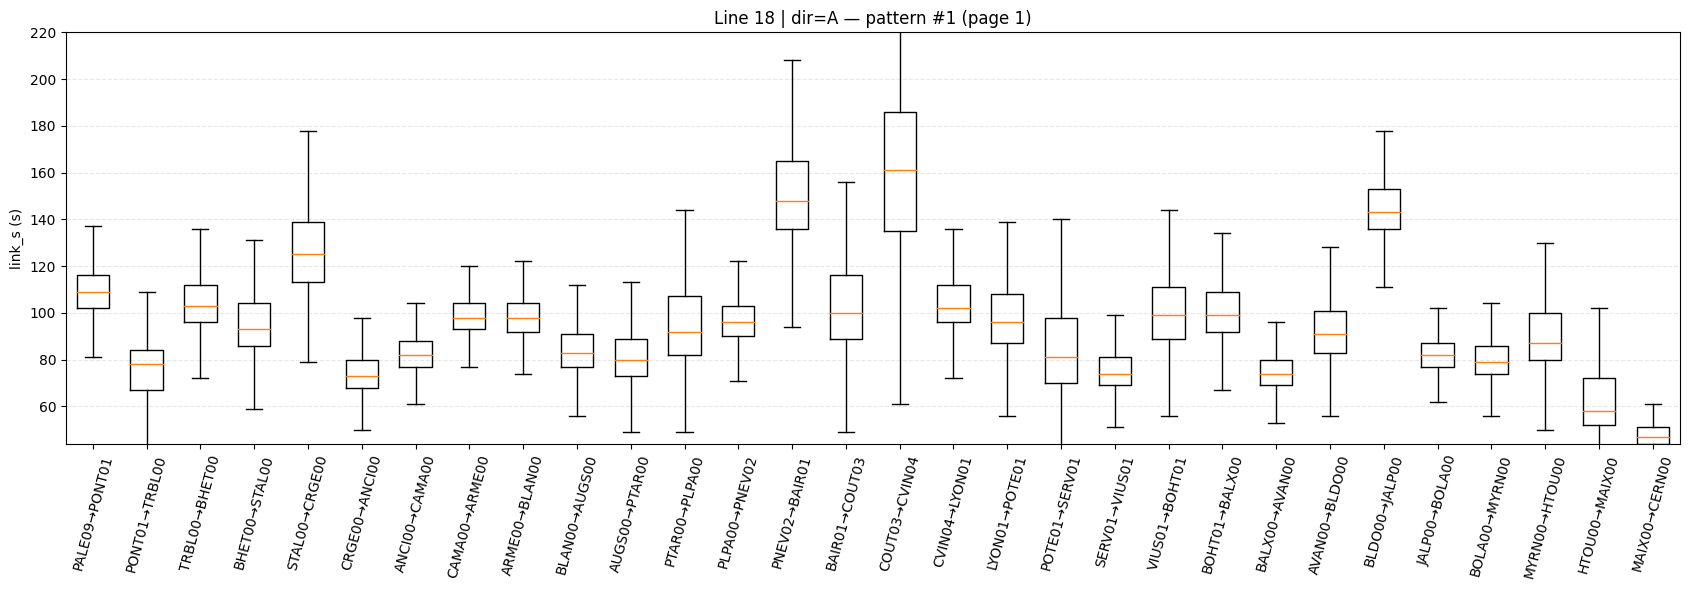


Pattern #2: share=26.6%, trips=7767, segments_kept=30, breaks=0


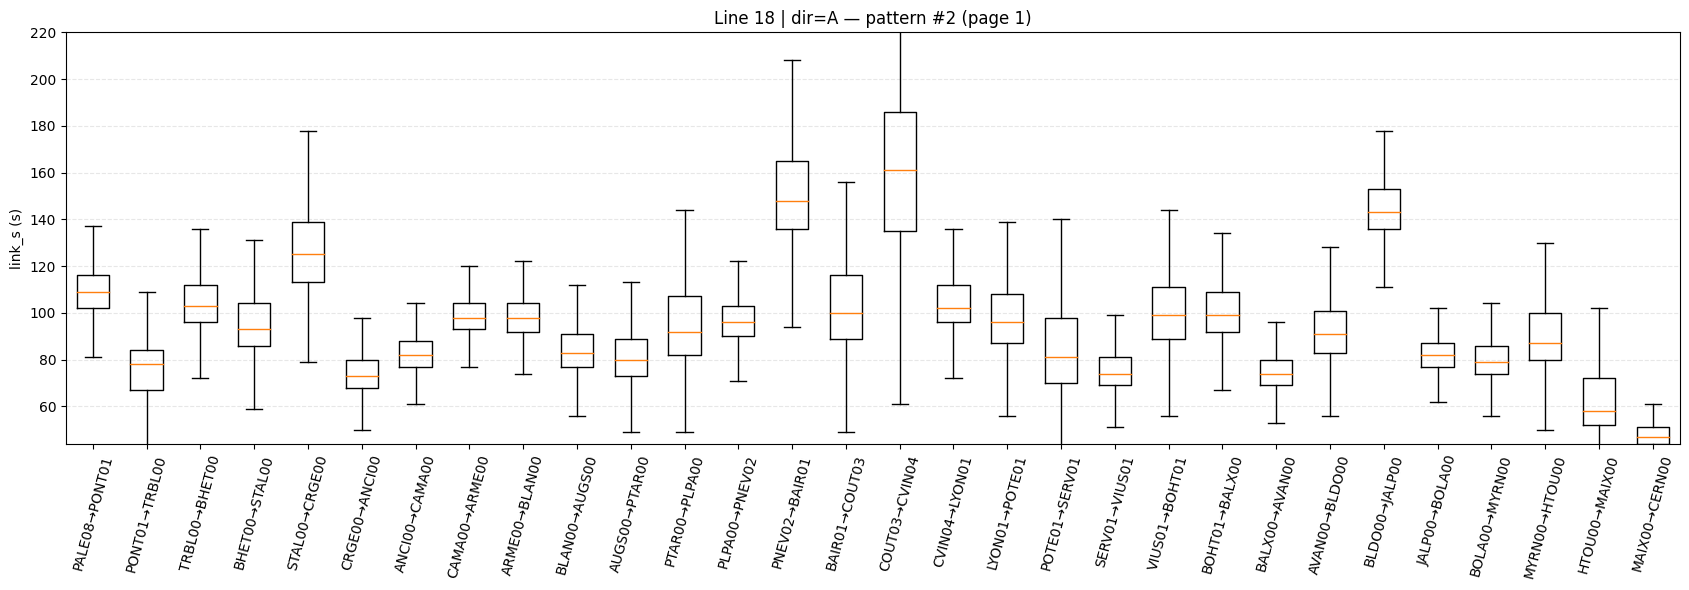

,n,median,p10,p25,p75,p90,IQR,p90-p10
SegmentKey,,,,,,,,
PALE09→PONT01,9204,109.0,94.0,102.0,116.0,124.0,14.0,30.0
PONT01→TRBL00,19955,78.0,57.0,67.0,84.0,89.0,17.0,32.0
TRBL00→BHET00,19917,103.0,87.0,96.0,112.0,125.0,16.0,38.0
BHET00→STAL00,18978,93.0,80.0,86.0,104.0,123.0,18.0,43.0
STAL00→CRGE00,18980,125.0,104.0,113.0,139.0,157.0,26.0,53.0
CRGE00→ANCI00,19522,73.0,62.0,68.0,80.0,89.0,12.0,27.0
ANCI00→CAMA00,19524,82.0,72.0,77.0,88.0,95.0,11.0,23.0
CAMA00→ARME00,19529,98.0,88.0,93.0,104.0,112.0,11.0,24.0
ARME00→BLAN00,19532,98.0,88.0,92.0,104.0,114.0,12.0,26.0


In [6]:
res18A = plot_line_by_patterns(seg=seg, seg_pat=seg_pat,
                              line=18, dir_="A",
                              top_k=2, min_share=0.15,
                              min_n_per_seg=20, per_fig_max_segments=50, figsize=(17,6))
res18A["pattern_1"]["spread"]

In [118]:
df_pat = extract_patterns(seg_pat, line=80, dir_="A", min_share=0)
display(df_pat)  # Jupyter, or print(df_pat.to_string(index=False))

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_93024/2183355692.py:205: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  paths = s.groupby("IdCourse", sort=False).apply(_trip_full_path)


,pattern_id,trips,share,n_segments,start,end,pattern_str,preview
0,1,19949,0.9360,22,BAIR07,SJSN04,BAIR07 → STND03 → PLDI00 → JOCT00 → QARV03 → E...,BAIR07 → STND03 → PLDI00 → … → SJHU00 → SJCE00...
1,2,849,0.0398,21,BAIR07,SJCE00,BAIR07 → STND03 → PLDI00 → JOCT00 → QARV03 → E...,BAIR07 → STND03 → PLDI00 → … → SJDO00 → SJHU00...
2,3,64,0.0030,17,ETOI00,SJSN04,ETOI00 → STGE00 → BHET05 → CMRE01 → AVIA00 → P...,ETOI00 → STGE00 → BHET05 → … → SJHU00 → SJCE00...
3,4,63,0.0030,19,BAIR07,SJSN04,BAIR07 → STND03 → PLDI00 → JOCT00 → QARV03 → C...,BAIR07 → STND03 → PLDI00 → … → SJHU00 → SJCE00...
4,5,20,0.0009,16,STGE00,SJSN04,STGE00 → BHET05 → CMRE01 → AVIA00 → PLOU00 → V...,STGE00 → BHET05 → CMRE01 → … → SJHU00 → SJCE00...
...,...,...,...,...,...,...,...,...
107,108,1,0.0000,21,BAIR07,SJSN04,BAIR07 → STND03 → JOCT00 → QARV03 → ETOI00 → S...,BAIR07 → STND03 → JOCT00 → … → SJHU00 → SJCE00...
108,109,1,0.0000,17,BAIR07,SJCE00,BAIR07 → STND03 → PLDI00 → JOCT00 → CMRE01 → A...,BAIR07 → STND03 → PLDI00 → … → SJDO00 → SJHU00...
109,110,1,0.0000,17,BAIR07,SJHU00,BAIR07 → STND03 → PLDI00 → JOCT00 → QARV03 → C...,BAIR07 → STND03 → PLDI00 → … → _PEDOF → SJDO00...
110,111,1,0.0000,12,BAIR07,RAVI00,BAIR07 → STND03 → PLDI00 → JOCT00 → CMRE01 → A...,BAIR07 → STND03 → PLDI00 → … → COTR01 → LOCH02...


In [149]:
# ==== 0) 只看 2024/10 的視圖 ====
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter

OCT_START = pd.Timestamp("2024-10-01")
NOV_START = pd.Timestamp("2024-10-31")

def make_october_views(seg, seg_src):
    # seg 已有 link_start_time，可直接切
    S = seg[(seg["link_start_time"] >= OCT_START) & (seg["link_start_time"] < NOV_START)].copy()

    # seg_pat 需從 seg_src 做（不看 anchor），時間用「能代表實際日期」的欄位來切
    # 依優先順序挑一個存在的時間欄位
    for tc in ["DTEntreeFenetreArretReal","DTSortieFenetreArretReal",
               "DTEntreeArretAtp","DTSortieArretAtp","DTDepartTheo","DTArriveeTheo"]:
        if tc in seg_src.columns:
            base_time = seg_src[tc]
            break
    else:
        # 最後退：若只有 DateCourse（字串）就轉成日期
        if "DateCourse" in seg_src.columns:
            base_time = pd.to_datetime(seg_src["DateCourse"], errors="coerce")
        else:
            raise ValueError("找不到能用來切 10 月的時間欄位")

    SS = seg_src[(base_time >= OCT_START) & (base_time < NOV_START)].copy()

    # 形成 seg_pat（保持你之前的邏輯）
    SS = SS.sort_values(["IdCourse","RangArretAsc"], kind="mergesort")
    SS["prev_CodeLong"] = SS.groupby("IdCourse")["CodeLong"].shift(1)
    seg_pat = SS.dropna(subset=["prev_CodeLong"]).copy()
    seg_pat["from_stop"] = seg_pat["prev_CodeLong"].astype(str).str.strip()
    seg_pat["to_stop"]   = seg_pat["CodeLong"].astype(str).str.strip()
    seg_pat["SegmentKey"] = seg_pat["from_stop"] + "→" + seg_pat["to_stop"]
    seg_pat["line"] = SS.get("C_Ligne").astype("Int64").astype(str)
    seg_pat["dir"]  = SS.get("C_SensAppl","NA").astype(str)

    return S, seg_pat

# ==== 1) 用 10 月資料找到最常見完整路徑（含起點） ====
def order_keys_by_top_pattern(seg_pat_oct, line, dir_=None, min_share=0.10):
    s = seg_pat_oct.copy()
    s = s[s["line"].astype(str) == str(line)]
    if dir_ is not None:
        s = s[s["dir"].astype(str) == str(dir_)]
    if s.empty:
        return []

    # 以每個班次的完整序列（[first_from] + list(to)）當 pattern
    s = s.sort_values(["IdCourse","RangArretAsc"], kind="mergesort")
    def _trip_full_path(g):
        first_from = g["from_stop"].iloc[0]
        return tuple([first_from] + g["to_stop"].tolist())
    paths = s.groupby("IdCourse", sort=False).apply(_trip_full_path)

    cnt = Counter(paths)
    total = sum(cnt.values())
    if total == 0:
        return []

    pat, n = cnt.most_common(1)[0]
    share = n / total
    if share < min_share:
        # 分享率不夠也先回傳（只是提醒）
        print(f"[warn] top pattern share only {share:.1%} (<{min_share:.0%})")

    ordered_keys = [f"{a}→{b}" for a,b in zip(pat[:-1], pat[1:])]
    return ordered_keys

# ==== 2A) 單一 period168 的 boxplot（看該時段的離散程度） ====
def plot_box_by_period(S_oct, ordered_keys, period168, line, dir_=None,
                       min_n_per_seg=15, figsize=(17,6)):
    s = S_oct.copy()
    s = s[(s["line"].astype(str)==str(line)) & (s["period168"]==period168)]
    if dir_ is not None:
        s = s[s["dir"].astype(str)==str(dir_)]

    # 只留 >0 的 link_s
    s = s[pd.to_numeric(s["link_s"], errors="coerce") > 0]
    if s.empty:
        print("no data in this period"); return

    # 篩掉樣本太少的段（但保留頭兩段，以免起站被吃掉）
    vc = s["SegmentKey"].value_counts()
    head = set(ordered_keys[:2])
    keep = set(vc[vc>=min_n_per_seg].index) | (head & set(vc.index))
    keys = [k for k in ordered_keys if k in keep]
    if not keys:
        print("all segments < min_n in this period"); return

    data = [s.loc[s["SegmentKey"]==k, "link_s"].values for k in keys]

    # y 軸用該 period 的 1–99 百分位，避免離群值拉扯
    y_lo = float(np.nanpercentile(s["link_s"], 1))
    y_hi = float(np.nanpercentile(s["link_s"], 99))

    plt.figure(figsize=figsize)
    bp = plt.boxplot(data, vert=True, showfliers=False, widths=0.6, labels=keys)
    plt.ylim(y_lo, y_hi)
    ttl = f"Line {line}"
    if dir_ is not None: ttl += f" | dir={dir_}"
    ttl += f" — period168={period168}"
    plt.title(ttl, fontsize=16)
    plt.ylabel("link_s (seconds)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.3, axis="y")
    plt.xticks(rotation=70, ha="right")

    # 在 x 標籤下方標註每段樣本數
    for i, k in enumerate(keys, start=1):
        n_i = len(data[i-1])
        plt.text(i, y_lo + 0.02*(y_hi-y_lo), f"n={n_i}", ha="center", va="bottom", fontsize=9, rotation=90)

    plt.tight_layout(); plt.show()

# ==== 2B) 168×segments 熱圖：變異度 (p90 - p10) ====
def plot_heatmap_spread(S_oct, ordered_keys, line, dir_=None, min_n=15, vmax=None, figsize=(18,6)):
    s = S_oct.copy()
    s = s[s["line"].astype(str)==str(line)]
    if dir_ is not None:
        s = s[s["dir"].astype(str)==str(dir_)]
    s = s[pd.to_numeric(s["link_s"], errors="coerce") > 0]
    s = s[s["SegmentKey"].isin(set(ordered_keys))]

    g = s.groupby(["SegmentKey","period168"])["link_s"]
    agg = g.agg(n="size",
                p10=lambda x: np.nanpercentile(x,10),
                p90=lambda x: np.nanpercentile(x,90)).reset_index()
    agg.loc[agg["n"]<min_n, ["p10","p90"]] = np.nan
    agg["spread"] = agg["p90"] - agg["p10"]

    mat = (agg.pivot(index="period168", columns="SegmentKey", values="spread")
              .reindex(index=range(168), columns=ordered_keys))

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(mat.to_numpy().T, aspect="auto", origin="upper",  # ← 上在上
                   interpolation="nearest", vmin=0, vmax=vmax)
    fig.colorbar(im, ax=ax, label="spread (p90 - p10) [s]")
    ax.set_yticks(range(len(ordered_keys)))
    ax.set_yticklabels(ordered_keys, fontsize=9)
    ax.set_xticks(range(0,168,6)); ax.set_xticklabels(range(0,168,6))
    ttl = f"Line {line}" + (f" | dir={dir_}" if dir_ is not None else "") + " — variability heatmap (p90-p10)"
    ax.set_title(ttl, fontsize=16)
    ax.set_xlabel("period168 (Mon00=0 … Sun23=167)")
    ax.set_ylabel("segments (top → bottom)")
    fig.tight_layout(); plt.show()

def plot_heatmap_spread_norm_per100m(S_oct, ordered_keys, line, dir_=None, min_n=15, vmax=None, figsize=(18,6)):
    s = S_oct.copy()
    s = s[(s["line"].astype(str)==str(line)) & (pd.to_numeric(s["link_s"], errors="coerce")>0)]
    if dir_ is not None:
        s = s[s["dir"].astype(str)==str(dir_)]
    s = s[s["SegmentKey"].isin(set(ordered_keys))]
    s = s[pd.to_numeric(s["distance_m"], errors="coerce")>0].copy()

    s["sec_per_100m"] = s["link_s"] / (s["distance_m"]/100.0)

    g = s.groupby(["SegmentKey","period168"])["sec_per_100m"]
    agg = g.agg(n="size",
                p10=lambda x: np.nanpercentile(x,10),
                p90=lambda x: np.nanpercentile(x,90)).reset_index()
    agg.loc[agg["n"]<min_n, ["p10","p90"]] = np.nan
    agg["spread"] = agg["p90"] - agg["p10"]   # 單位：秒/100m

    mat = (agg.pivot(index="period168", columns="SegmentKey", values="spread")
              .reindex(index=range(168), columns=ordered_keys))

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(mat.to_numpy().T, aspect="auto", origin="upper",
                   interpolation="nearest", vmin=0, vmax=vmax)
    fig.colorbar(im, ax=ax, label="spread (p90 - p10) [sec/100m]")
    ax.set_yticks(range(len(ordered_keys))); ax.set_yticklabels(ordered_keys, fontsize=9)
    ax.set_xticks(range(0,168,6)); ax.set_xticklabels(range(0,168,6))
    ax.set_title(f"Line {line}" + (f" | dir={dir_}" if dir_ else "") + " — variability per distance", fontsize=16)
    ax.set_xlabel("period168"); ax.set_ylabel("segments (top → bottom)")
    fig.tight_layout(); plt.show()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import colors

# ---- 1) 找「完整停靠序列」的 top patterns（同你現在的 seg_pat 流程）----
def _top_patterns(seg_line_dir, top_k=1, min_share=0.10):
    s = seg_line_dir.copy()
    if "RangArretAsc" in s.columns:
        s = s.sort_values(["IdCourse","RangArretAsc"], kind="mergesort")
    else:
        s = s.sort_values(["IdCourse","link_start_time"], kind="mergesort")
    if ("from_stop" not in s.columns) or ("to_stop" not in s.columns):
        a = s["SegmentKey"].str.split("→", expand=True)
        s["from_stop"] = a[0].astype(str).str.strip()
        s["to_stop"]   = a[1].astype(str).str.strip()
    else:
        s["from_stop"] = s["from_stop"].astype(str).str.strip()
        s["to_stop"]   = s["to_stop"].astype(str).str.strip()

    def _trip_full_path(g):
        first_from = g["from_stop"].iloc[0]
        to_seq     = g["to_stop"].tolist()
        return tuple([first_from] + to_seq)

    paths = s.groupby("IdCourse", sort=False).apply(_trip_full_path)
    cnt = Counter(paths); total = sum(cnt.values()) if cnt else 0
    ranked = [(p, n, n/total) for p, n in cnt.most_common() if total>0 and (n/total)>=min_share]
    return ranked[:top_k]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# --- 跟你現有的一樣：找最常見的完整停靠序列（含起點） ---
def _top_patterns(seg_line_dir, top_k=1, min_share=0.10):
    s = seg_line_dir.copy()
    if "RangArretAsc" in s.columns:
        s = s.sort_values(["IdCourse","RangArretAsc"], kind="mergesort")
    else:
        s = s.sort_values(["IdCourse","link_start_time"], kind="mergesort")
    if ("from_stop" not in s.columns) or ("to_stop" not in s.columns):
        a = s["SegmentKey"].str.split("→", expand=True)
        s["from_stop"] = a[0].astype(str).str.strip()
        s["to_stop"]   = a[1].astype(str).str.strip()
    else:
        s["from_stop"] = s["from_stop"].astype(str).str.strip()
        s["to_stop"]   = s["to_stop"].astype(str).str.strip()

    def _trip_full_path(g):
        first_from = g["from_stop"].iloc[0]
        to_seq     = g["to_stop"].tolist()
        return tuple([first_from] + to_seq)

    paths = s.groupby("IdCourse", sort=False).apply(_trip_full_path)
    cnt = Counter(paths); total = sum(cnt.values()) if cnt else 0
    ranked = [(p, n, n/total) for p, n in cnt.most_common() if total>0 and (n/total)>=min_share]
    return ranked[:top_k]

# --- p50 熱圖（含距離校正版本） ---
def plot_p50_heatmap_with_distance(
    seg, seg_pat, line, dir_="A",
    month_from="2024-10-01", month_to="2024-10-31",
    min_n=10, norm_unit_m=100,
    show_raw=True, show_norm=True,
    cmap_raw="magma", cmap_norm="cividis",
    figsize=(18,6)
):
    # 1) 用 seg_pat 決定 row 順序（不漏掉起站第一段）
    s_pat = seg_pat[(seg_pat["line"].astype(str)==str(line)) & (seg_pat["dir"].astype(str)==str(dir_))].copy()
    pats = _top_patterns(s_pat, top_k=1, min_share=0.05)
    if not pats:
        print("No dominant pattern for this line/dir."); return
    pat, trips, share = pats[0]
    ordered_keys = [f"{a}→{b}" for a,b in zip(pat[:-1], pat[1:])]

    # 2) 取指定月份 + 有效 link_s 的資料
    s = seg[(seg["line"].astype(str)==str(line)) & (seg["dir"].astype(str)==str(dir_))].copy()
    s = s[(s["link_start_time"]>=pd.to_datetime(month_from)) & (s["link_start_time"]<=pd.to_datetime(month_to))]
    s = s[pd.to_numeric(s["link_s"], errors="coerce") > 0]
    if s.empty:
        print("No positive link_s data in given month range."); return

    # 3) 各段×period168 的 p50 與樣本數
    g = (s.groupby(["SegmentKey","period168"])["link_s"]
           .agg(n="size", p50=lambda x: float(np.nanmedian(x)))).reset_index()
    g.loc[g["n"] < min_n, "p50"] = np.nan

    mat_raw = (g.pivot(index="SegmentKey", columns="period168", values="p50")
                 .reindex(index=ordered_keys))
    keep_rows = mat_raw.index[mat_raw.notna().any(axis=1)].tolist()
    mat_raw = mat_raw.loc[keep_rows]

    # 4) 距離校正：拿同一段在 seg 中的距離（中位數），計算 秒/100m
    #    缺距離或<=0 的段一律留白
    dist_per_seg = (s.groupby("SegmentKey")["distance_m"]
                      .median().reindex(mat_raw.index))
    dist_vec = dist_per_seg.to_numpy()
    with np.errstate(divide='ignore', invalid='ignore'):
        mat_norm_vals = mat_raw.to_numpy() / (dist_vec[:, None] / float(norm_unit_m))
    mat_norm = pd.DataFrame(mat_norm_vals, index=mat_raw.index, columns=mat_raw.columns)
    mat_norm[(~np.isfinite(mat_norm)) | (dist_vec[:,None] <= 0)] = np.nan  # 無距離→留白

    # 5) 畫圖：按需求顯示 raw / norm
    n_panels = int(show_raw) + int(show_norm)
    fig, axs = plt.subplots(1, n_panels, figsize=figsize, squeeze=False)
    axs = axs[0]

    # x 軸輔助
    def style_xaxis(ax):
        ax.set_xlim(-0.5, 167.5)
        for d in range(1,7):
            ax.axvline(d*24-0.5, color="k", lw=1, alpha=0.25)
        ax.set_xticks(np.arange(0, 168, 6))
        ax.set_xlabel("period168 (Mon00=0 … Sun23=167)")

    # y 軸（上→下=行駛方向）
    def style_yaxis(ax, idx):
        ax.set_yticks(np.arange(len(idx)))
        ax.set_yticklabels(idx)
        ax.set_ylabel("segments (top → bottom)")

    # 色階範圍：用 1–99 分位，避免極端值
    vmin_raw = np.nanpercentile(mat_raw.values, 1) if show_raw else None
    vmax_raw = np.nanpercentile(mat_raw.values, 99) if show_raw else None
    vmin_norm = np.nanpercentile(mat_norm.values, 1) if show_norm else None
    vmax_norm = np.nanpercentile(mat_norm.values, 99) if show_norm else None

    pane = 0
    if show_raw:
        cmap = plt.get_cmap(cmap_raw).copy(); cmap.set_bad("white")
        im = axs[pane].imshow(mat_raw.values, aspect="auto", origin="upper",
                              interpolation="nearest", cmap=cmap,
                              vmin=vmin_raw, vmax=vmax_raw)
        style_xaxis(axs[pane]); style_yaxis(axs[pane], mat_raw.index)
        cbar = fig.colorbar(im, ax=axs[pane])
        cbar.set_label("median link_s (p50) [s]")
        axs[pane].set_title(f"Line {line} | dir={dir_} — p50 (seconds)  [{month_from[:7]}]")
        pane += 1

    if show_norm:
        cmap = plt.get_cmap(cmap_norm).copy(); cmap.set_bad("white")
        im = axs[pane].imshow(mat_norm.values, aspect="auto", origin="upper",
                              interpolation="nearest", cmap=cmap,
                              vmin=vmin_norm, vmax=vmax_norm)
        style_xaxis(axs[pane]); style_yaxis(axs[pane], mat_norm.index)
        cbar = fig.colorbar(im, ax=axs[pane])
        cbar.set_label(f"median link_s per {norm_unit_m} m (p50) [s/{norm_unit_m}m]")
        axs[pane].set_title(f"Line {line} | dir={dir_} — p50 (sec/{norm_unit_m}m)  [{month_from[:7]}]")

    plt.tight_layout()
    plt.show()

    return {
        "ordered_keys": ordered_keys,
        "pattern_share": share,
        "trips_in_pattern": trips,
        "mat_raw": mat_raw,
        "mat_norm": mat_norm,
        "dist_per_seg": dist_per_seg
    }



/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_93024/2141090429.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  paths = s.groupby("IdCourse", sort=False).apply(_trip_full_path)


30 ['PALE09→PONT01', 'PONT01→TRBL00', 'TRBL00→BHET00', 'BHET00→STAL00', 'STAL00→CRGE00'] ...
all segments < min_n in this period


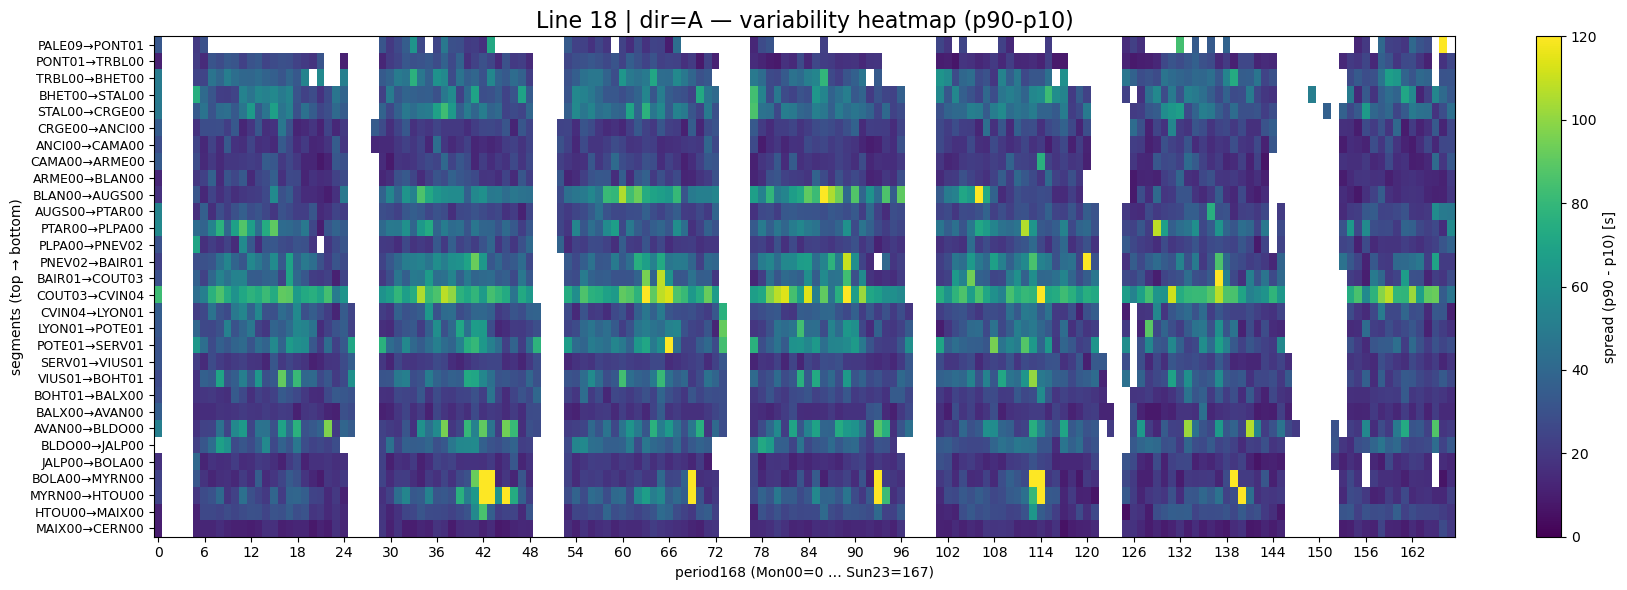

In [152]:
# 只取 2024/10 視圖
S_oct, seg_pat_oct = make_october_views(seg, seg_src)

# 先決定 Line / Dir 的順序（用 10 月 top pattern）
ordered = order_keys_by_top_pattern(seg_pat_oct, line=18, dir_="A", min_share=0.10)
print(len(ordered), ordered[:5], "...")

# (A) 指定某個 period168 看「該時段」的分布
plot_box_by_period(S_oct, ordered, period168= (2*24 + 8),  # 例：Wed 08:00 → 2*24+8=56
                   line=80, dir_="A", min_n_per_seg=10)

# (B) 看整個 168×segments 的變異熱圖
plot_heatmap_spread(S_oct, ordered, line=18, dir_="A", min_n=10, vmax=120)

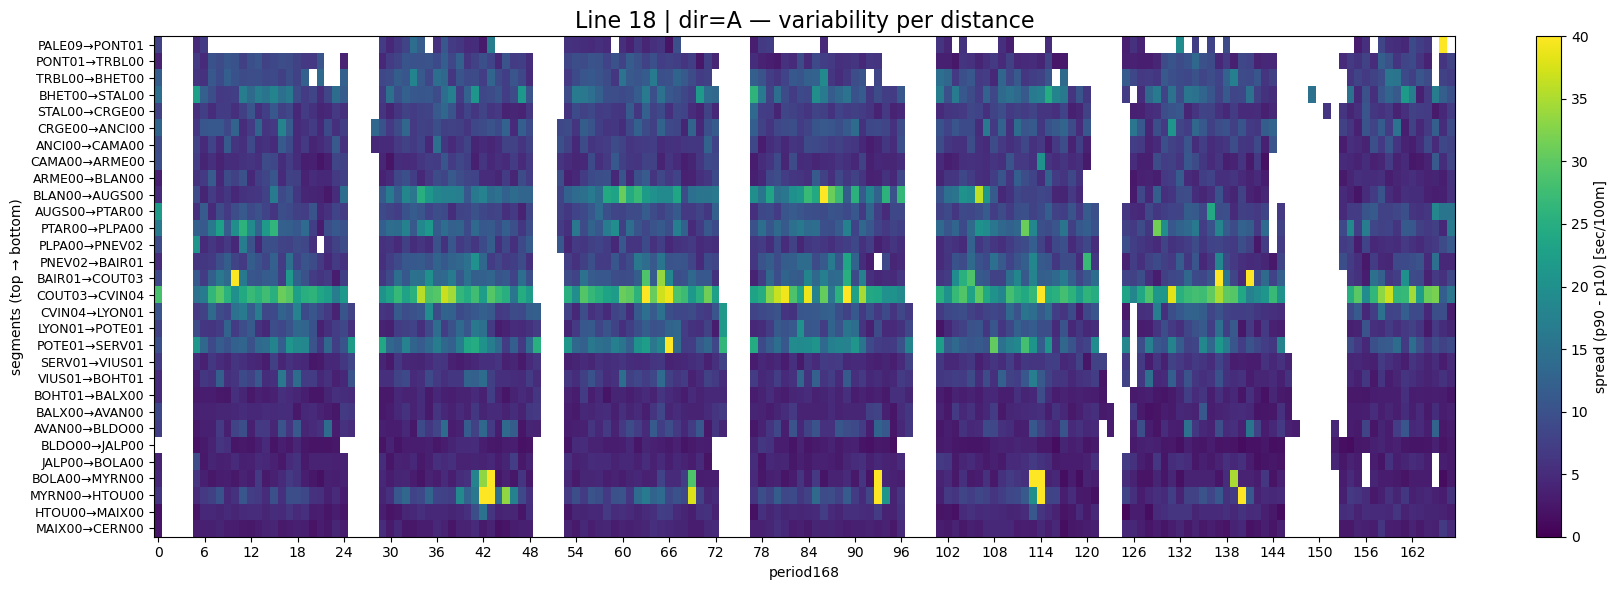

In [153]:
plot_heatmap_spread_norm_per100m(S_oct, ordered, line=18, dir_="A", min_n=10, vmax=40.0)

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_93024/2141090429.py:232: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  paths = s.groupby("IdCourse", sort=False).apply(_trip_full_path)


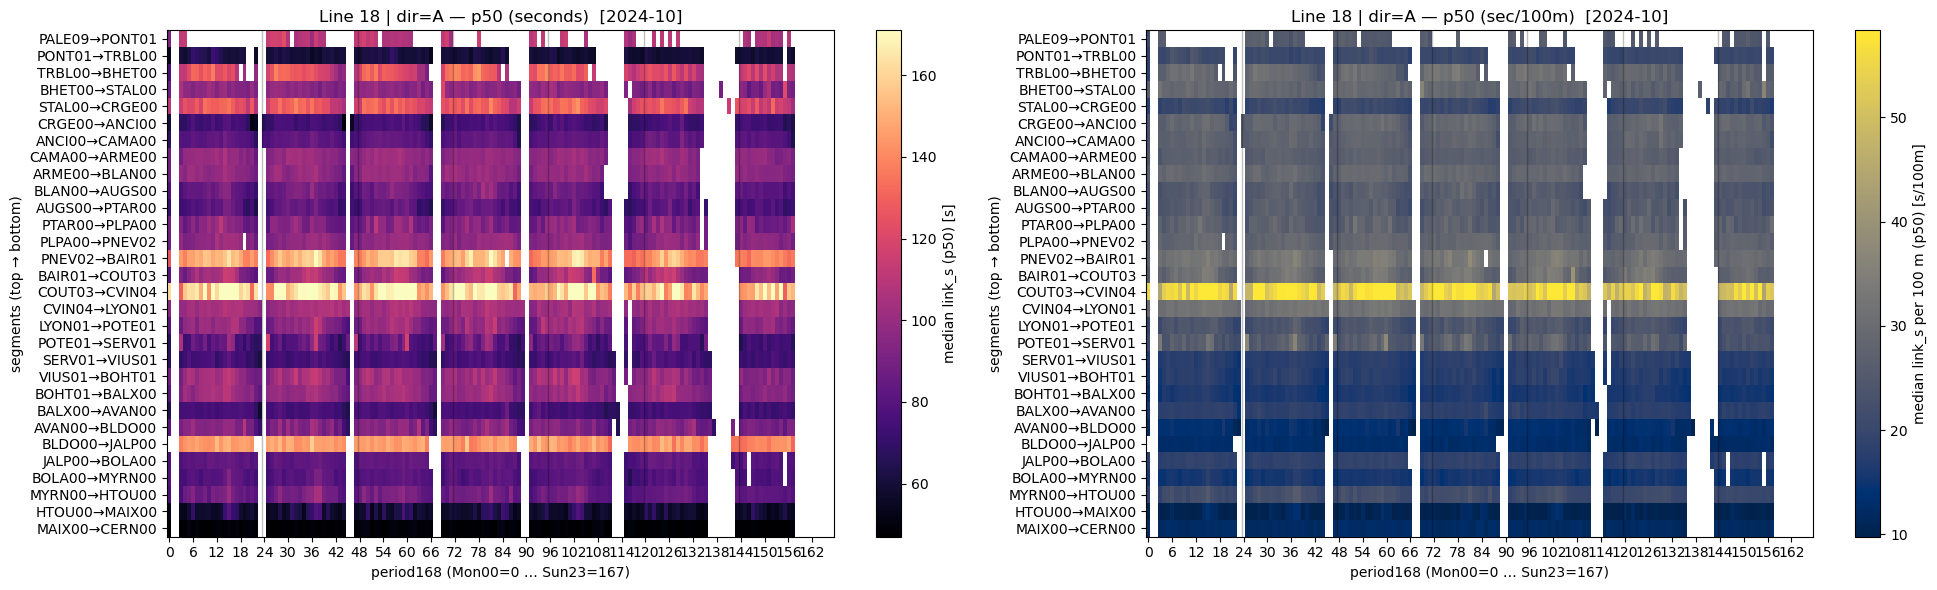

{'ordered_keys': ['PALE09→PONT01',
  'PONT01→TRBL00',
  'TRBL00→BHET00',
  'BHET00→STAL00',
  'STAL00→CRGE00',
  'CRGE00→ANCI00',
  'ANCI00→CAMA00',
  'CAMA00→ARME00',
  'ARME00→BLAN00',
  'BLAN00→AUGS00',
  'AUGS00→PTAR00',
  'PTAR00→PLPA00',
  'PLPA00→PNEV02',
  'PNEV02→BAIR01',
  'BAIR01→COUT03',
  'COUT03→CVIN04',
  'CVIN04→LYON01',
  'LYON01→POTE01',
  'POTE01→SERV01',
  'SERV01→VIUS01',
  'VIUS01→BOHT01',
  'BOHT01→BALX00',
  'BALX00→AVAN00',
  'AVAN00→BLDO00',
  'BLDO00→JALP00',
  'JALP00→BOLA00',
  'BOLA00→MYRN00',
  'MYRN00→HTOU00',
  'HTOU00→MAIX00',
  'MAIX00→CERN00'],
 'pattern_share': 0.29409548599219126,
 'trips_in_pattern': 8587,
 'mat_raw': period168        0    1    4      5      6      7      8      9      10   \
 SegmentKey                                                                 
 PALE09→PONT01   93.0  NaN  NaN  112.0  113.5    NaN    NaN    NaN    NaN   
 PONT01→TRBL00   54.0  NaN  NaN   60.5   58.0   62.0   71.0   68.0   66.0   
 TRBL00→BHET00   76.0  NaN  

In [154]:
plot_p50_heatmap_with_distance(
        seg=seg, seg_pat=seg_pat, line=18, dir_="A",
        month_from="2024-10-01", month_to="2024-10-31",
        min_n=10, norm_unit_m=100,
        show_raw=True, show_norm=True,
        cmap_raw="magma", cmap_norm="cividis",
        figsize=(20,6)
)

In [73]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def _top_patterns(seg_line_dir, top_k=1, min_share=0.10):
    s = seg_line_dir.copy()
    if "RangArretAsc" in s.columns:
        s = s.sort_values(["IdCourse","RangArretAsc"], kind="mergesort")
    else:
        s = s.sort_values(["IdCourse","link_start_time"], kind="mergesort")
    if "from_stop" not in s or "to_stop" not in s:
        a = s["SegmentKey"].str.split("→", expand=True)
        s["from_stop"] = a[0].astype(str).str.strip()
        s["to_stop"]   = a[1].astype(str).str.strip()

    def _trip_full_path(g):
        return tuple([g["from_stop"].iloc[0]] + g["to_stop"].tolist())

    paths = s.groupby("IdCourse", sort=False).apply(_trip_full_path)
    from collections import Counter
    cnt = Counter(paths); tot = sum(cnt.values())
    ranked = [(p,n,n/tot) for p,n in cnt.most_common() if tot>0 and n/tot>=min_share]
    return ranked[:top_k]

def plot_p50_heatmap_with_distance(seg, seg_pat, line, dir_="A",
                                   month_from="2024-10-01", month_to="2024-10-31",
                                   min_n=10, norm_unit_m=100,
                                   show_raw=True, show_norm=True,
                                   cmap_raw="magma", cmap_norm="cividis",
                                   figsize=(20,6)):
    # ---- 篩資料（只看該月）----
    s = seg[(seg["line"].astype(str)==str(line)) & (seg["dir"].astype(str)==str(dir_))].copy()
    s = s[(s["link_start_time"]>=pd.to_datetime(month_from)) &
          (s["link_start_time"]<=pd.to_datetime(month_to))].copy()

    # period168 一定要是 int，且補齊 0..167
    s["period168"] = (s["period168"].astype("Int64")).astype(int)

    # 依最常見 pattern 取順序（用 seg_pat，避免起站掉）
    sp0 = seg_pat[(seg_pat["line"].astype(str)==str(line)) & (seg_pat["dir"].astype(str)==str(dir_))].copy()
    pats = _top_patterns(sp0, top_k=1, min_share=0.05)
    if not pats:
        print("No dominant pattern."); return
    pat,_n,_share = pats[0][0], pats[0][1], pats[0][2]
    ordered_keys = [f"{a}→{b}" for a,b in zip(pat[:-1], pat[1:])]

    # 只保留在 seg 有測得 link_s 的段，且樣本數 >= min_n（但前兩段強制保留）
    s = s[s["SegmentKey"].isin(set(ordered_keys))].copy()
    vc = s["SegmentKey"].value_counts()
    head_keep = set(ordered_keys[:2])
    keep = set(vc[vc>=min_n].index) | (head_keep & set(vc.index))
    ordered_keys = [k for k in ordered_keys if k in keep]
    s = s[s["SegmentKey"].isin(ordered_keys)].copy()

    # 距離
    s["distance_m"] = pd.to_numeric(s["distance_m"], errors="coerce")

    # ---- 聚合：每段 × period168 的 p50（秒），與距離校正（秒/100m）----
    def _agg_one(df):
        out = {"p50": float(np.nanquantile(df["link_s"], 0.5))}
        # per 100m：用「秒/100m」的中位數（中位數在此作用像 robust 比率）
        m = (df["distance_m"]>0) & df["link_s"].notna()
        out["p50_per100m"] = float(np.nanquantile(df.loc[m,"link_s"] / (df.loc[m,"distance_m"]/norm_unit_m), 0.5)) if m.any() else np.nan
        return pd.Series(out)

    g = s.groupby(["SegmentKey","period168"]).apply(_agg_one).reset_index()

    # 轉寬 + 補齊 0..167 欄
    def _pivot(col):
        pv = g.pivot(index="SegmentKey", columns="period168", values=col)
        pv = pv.reindex(index=ordered_keys, columns=range(168))   # 補齊欄、確保順序
        return pv

    H_raw  = _pivot("p50")
    H_norm = _pivot("p50_per100m")

    # ---- 畫圖（用 extent 對齊 cell，vline 在邊界 -0.5）----
    nseg = len(ordered_keys)
    ncols = (show_raw and show_norm) + 1
    fig, axes = plt.subplots(1, ncols, figsize=figsize, constrained_layout=True)

    def _imshow(ax, M, ttl, cmap, cbar_label):
        im = ax.imshow(M.values, aspect="auto", origin="upper",
                       cmap=cmap, interpolation="nearest",
                       extent=[-0.5, 167.5, -0.5, nseg-0.5])
        # y tick
        ax.set_yticks(np.arange(nseg))
        ax.set_yticklabels(ordered_keys)
        ax.set_ylabel("segments (top → bottom)")
        # x tick與分隔
        ax.set_xlabel("period168 (Mon00=0 ... Sun23=167)")
        for d in range(1,7):
            ax.axvline(d*24-0.5, color="white", lw=2, alpha=0.8)
        ax.set_title(ttl)
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label(cbar_label)
        return ax

    if show_raw and show_norm:
        _imshow(axes[0], H_raw,  f"Line {line} | dir={dir_} — p50 (seconds)   [{month_from[:7]}]",
                cmap_raw,  "median link_s (p50) [s]")
        _imshow(axes[1], H_norm, f"Line {line} | dir={dir_} — p50 (sec/{norm_unit_m}m)   [{month_from[:7]}]",
                cmap_norm, f"median link_s per {norm_unit_m} m (p50) [s/{norm_unit_m}m]")
    elif show_raw:
        _imshow(axes, H_raw,  f"Line {line} | dir={dir_} — p50 (seconds)   [{month_from[:7]}]",
                cmap_raw,  "median link_s (p50) [s]")
    else:
        _imshow(axes, H_norm, f"Line {line} | dir={dir_} — p50 (sec/{norm_unit_m}m)   [{month_from[:7]}]",
                cmap_norm, f"median link_s per {norm_unit_m} m (p50) [s/{norm_unit_m}m]")

    plt.show()

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_93024/2095833881.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  paths = s.groupby("IdCourse", sort=False).apply(_trip_full_path)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_93024/2095833881.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g = s.groupby(["SegmentKey","period168"]).apply(_agg_one).reset_index()


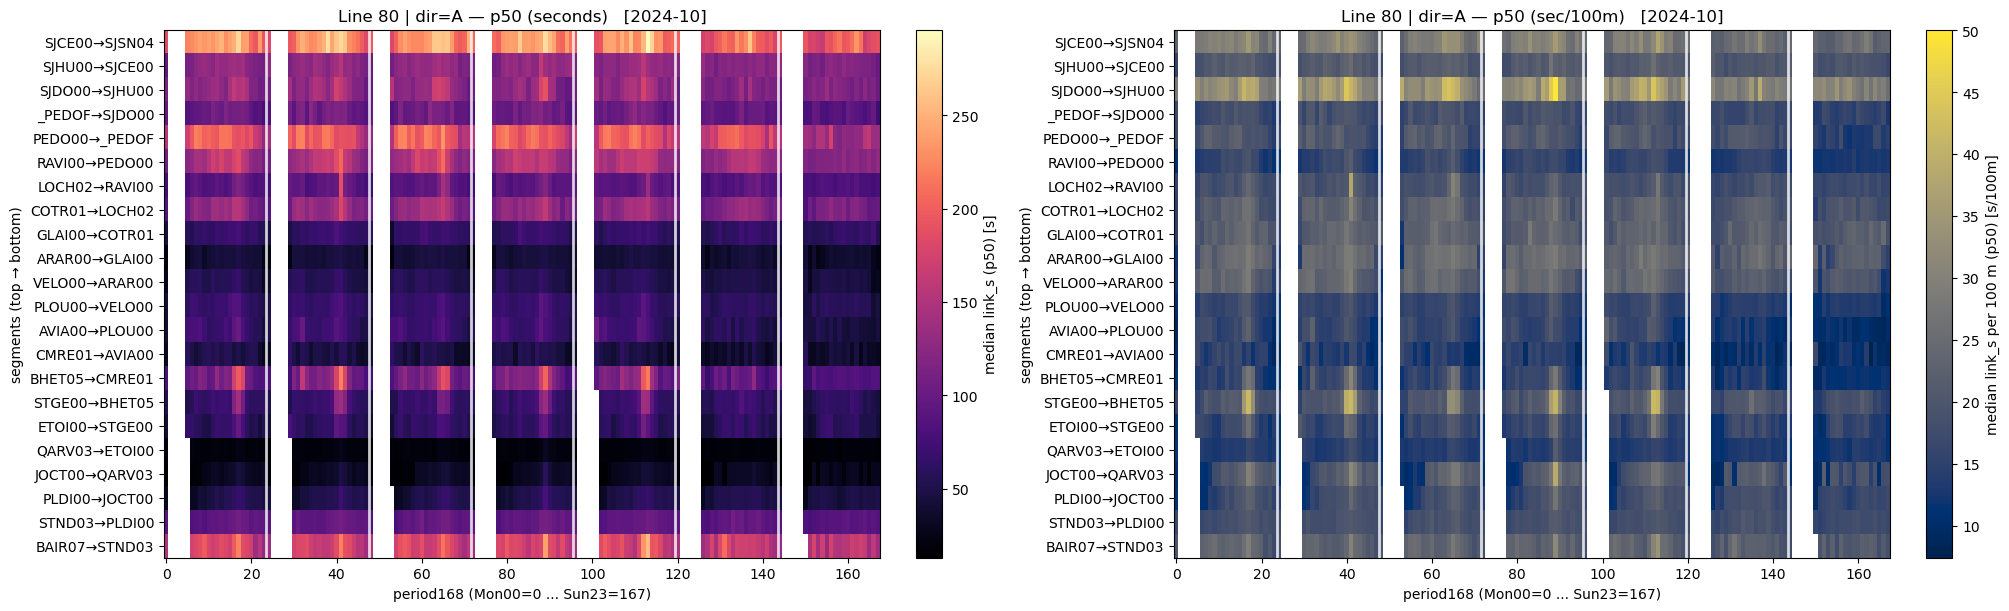

In [74]:
plot_p50_heatmap_with_distance(
        seg=seg, seg_pat=seg_pat, line=80, dir_="A",
        month_from="2024-10-01", month_to="2024-10-31",
        min_n=10, norm_unit_m=100,
        show_raw=True, show_norm=True,
        cmap_raw="magma", cmap_norm="cividis",
        figsize=(20,6)
)

In [75]:
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error

# ---- 你已經有的：LEVELS、_fit_level_quantile、fit_maps、apply_maps、make_empirical_baseline ----
# (略) 直接沿用你現有版本

def pinball_loss(y, qhat, alpha):
    m = np.isfinite(y) & np.isfinite(qhat)
    if not m.any(): return np.nan
    e = y[m] - qhat[m]
    return float(np.mean(np.maximum(alpha*e, (alpha-1)*e)))

def mae(y, yhat):
    m = np.isfinite(y) & np.isfinite(yhat)
    return float(np.mean(np.abs(y[m]-yhat[m]))) if m.any() else np.nan

def coverage(y, qhat):
    m = np.isfinite(y) & np.isfinite(qhat)
    return float(np.mean(y[m] <= qhat[m])) if m.any() else np.nan

# 1) 準備日期切點（以週為例；要改月也很簡單）
def weekly_cutpoints(s, min_weeks_train=4):
    dt = pd.to_datetime(s["link_start_time"])
    wk = (dt.dt.to_period("W").apply(lambda p: p.start_time)).rename("week")
    s = s.assign(_week=wk)
    weeks = sorted(s["_week"].unique())
    cuts = []
    for i in range(min_weeks_train, len(weeks)):
        train_to = weeks[i-1]            # 包含這一週
        test_week = weeks[i]             # 預測下一週
        cuts.append((train_to, test_week))
    return s, cuts

# 2) 單一回合：產生 p50/p85 baseline 並計算指標（含距離校正）
def eval_one_round(train_df, test_df, target="link_s", levels=None, q_main=0.50, q_hi=0.85):
    # fit maps
    b50, _, _, _ = make_empirical_baseline(train_df, test_df, target=target, q=q_main, levels=levels)
    b85, _, _, _ = make_empirical_baseline(train_df, test_df, target=target, q=q_hi,   levels=levels)

    y = test_df[target].to_numpy(dtype=float)
    d = test_df["distance_m"].to_numpy(dtype=float)

    out = {
        "MAE_p50": mae(y, b50),
        "MedAE_p50": float(np.nanmedian(np.abs(y - b50))),
        "Pinball@0.85": pinball_loss(y, b85, 0.85),
        "Coverage@0.85": coverage(y, b85),
    }
    # 距離校正
    m = np.isfinite(y) & np.isfinite(b50) & np.isfinite(d) & (d>0)
    out["MAE_p50_per100m"] = float(np.mean(np.abs(y[m]-b50[m]) / (d[m]/100))) if m.any() else np.nan
    out["MedAE_p50_per100m"] = float(np.nanmedian(np.abs(y[m]-b50[m]) / (d[m]/100))) if m.any() else np.nan
    return out, b50, b85

# 3) 週度滾動回測
def rolling_backtest(seg, target="link_s", levels=None, min_weeks_train=4):
    s, cuts = weekly_cutpoints(seg.dropna(subset=[target, "link_start_time"]), min_weeks_train)
    rows = []
    all_preds = []
    for train_to, test_week in cuts:
        tr = s[s["_week"] <= train_to].copy()
        te = s[s["_week"] == test_week].copy()
        if len(te)==0 or len(tr)==0: 
            continue
        met, p50, p85 = eval_one_round(tr, te, target=target, levels=levels)
        met["train_to"] = train_to; met["test_week"] = test_week; met["n_test"] = len(te)
        rows.append(met)
    res = pd.DataFrame(rows).sort_values("test_week")
    return res

# ---- 跑起來（link_s）----
LEVELS = [
    ["SegmentKey","period168"],
    ["SegmentKey","is_weekend","hour"],
    ["SegmentKey"],
]
bt = rolling_backtest(seg, target="link_s", levels=LEVELS, min_weeks_train=4)

# 整體回答（平均 & 中位數）
summary = bt.agg({
    "MAE_p50":["mean","median"],
    "MedAE_p50":["mean","median"],
    "Coverage@0.85":["mean","median"],
    "Pinball@0.85":["mean","median"],
    "MAE_p50_per100m":["mean","median"],
    "MedAE_p50_per100m":["mean","median"],
    "n_test":"sum",
})
print(summary)

          MAE_p50  MedAE_p50  Coverage@0.85  Pinball@0.85  MAE_p50_per100m  \
mean    16.540102   9.148148       0.844533      6.520138         4.300495   
median  16.329271   9.000000       0.845373      6.545364         4.153938   
sum           NaN        NaN            NaN           NaN              NaN   

        MedAE_p50_per100m     n_test  
mean             2.215178        NaN  
median           2.184670        NaN  
sum                   NaN  1901060.0  


          MAE_p50  MedAE_p50  Coverage@0.85  Pinball@0.85  MAE_p50_per100m  \
mean    16.540102   9.148148       0.844533      6.520138         4.300495   
median  16.329271   9.000000       0.845373      6.545364         4.153938   
sum           NaN        NaN            NaN           NaN              NaN   

        MedAE_p50_per100m     n_test  
mean             2.215178        NaN  
median           2.184670        NaN  
sum                   NaN  1901060.0  


### Dwell/Runtime segments

In [119]:
import numpy as np
import pandas as pd
from collections import Counter

# ------------------------------
# Build window-based micro-segments (dwell + runtime)
# ------------------------------
def build_window_microsegments(seg_src, window_total_m=70):
    """
    Create a dataframe 'winseg' with dwell and runtime segments defined by window timestamps.
    Nodes are 'CodeLong|Entree' and 'CodeLong|Sortie'.
    Returns columns:
      - IdCourse, line, dir, trip_seq (ordering index)
      - from_node, to_node, type ('dwell'|'run'), duration_s, start_time, end_time
      - from_stop, to_stop, SegmentKey_win
      - distance_m (dwell=window_total_m; runtime=max(DistanceInterArret - window_total_m, 0) if available)
    """
    s = seg_src.copy()

    # ensure datetimes
    for c in ["DTEntreeFenetreArretReal","DTSortieFenetreArretReal","DTEntreeArretAtp","DTSortieArretAtp",
              "DTDepartTheo","DTArriveeTheo"]:
        if c in s.columns:
            s[c] = pd.to_datetime(s[c], errors="coerce")

    # basic ids
    if "RangArretAsc" in s.columns:
        s["RangArretAsc"] = pd.to_numeric(s["RangArretAsc"], errors="coerce")
    if "C_Ligne" in s.columns:
        s["C_Ligne"] = pd.to_numeric(s["C_Ligne"], errors="coerce")

    # sort trip order
    if "IdCourse" in s.columns:
        s = s.sort_values(["IdCourse","RangArretAsc"], kind="mergesort")
        g = s.groupby("IdCourse", sort=False)
    else:
        # fallback (line/date)
        s = s.sort_values(["C_Ligne","DateCourse","RangArretAsc"], kind="mergesort")
        g = s.groupby(["C_Ligne","DateCourse"], sort=False)

    # clean stop ids
    s["CodeLong"] = s.get("CodeLong","").astype(str).str.strip()
    s["line"] = s.get("C_Ligne").astype("Int64").astype(str) if "C_Ligne" in s.columns else "NA"
    s["dir"]  = s.get("C_SensAppl","NA").astype(str)

    # distances
    dist = pd.to_numeric(s.get("DistanceInterArret"), errors="coerce")

    # shift next stop's Entree for runtime construction
    s["next_Entree"]  = g["DTEntreeFenetreArretReal"].shift(-1)
    s["next_CodeLong"] = g["CodeLong"].shift(-1)

    # build dwell rows (where both window times exist)
    dwell_mask = s["DTEntreeFenetreArretReal"].notna() & s["DTSortieFenetreArretReal"].notna()
    dwell = s.loc[dwell_mask, [
        "IdCourse","line","dir","CodeLong","DTEntreeFenetreArretReal","DTSortieFenetreArretReal","RangArretAsc"
    ]].copy()
    dwell["from_node"] = dwell["CodeLong"] + "|Entree"
    dwell["to_node"]   = dwell["CodeLong"] + "|Sortie"
    dwell["type"] = "dwell"
    dwell["start_time"] = dwell["DTEntreeFenetreArretReal"]
    dwell["end_time"]   = dwell["DTSortieFenetreArretReal"]
    dwell["duration_s"] = (dwell["end_time"] - dwell["start_time"]).dt.total_seconds()
    dwell["from_stop"]  = dwell["CodeLong"]
    dwell["to_stop"]    = dwell["CodeLong"]
    dwell["SegmentKey_win"] = dwell["from_node"] + "→" + dwell["to_node"]
    dwell["distance_m"] = float(window_total_m)

    # QC dwell
    dwell.loc[(dwell["duration_s"]<=0) | (dwell["duration_s"]>900), "duration_s"] = np.nan

    # build runtime rows (need current Sortie and next Entree)
    run_mask = s["DTSortieFenetreArretReal"].notna() & s["next_Entree"].notna()
    run = s.loc[run_mask, [
        "IdCourse","line","dir","CodeLong","DTSortieFenetreArretReal","next_Entree","next_CodeLong","RangArretAsc"
    ]].copy()
    run["from_node"] = run["CodeLong"] + "|Sortie"
    run["to_node"]   = run["next_CodeLong"] + "|Entree"
    run["type"] = "run"
    run["start_time"] = run["DTSortieFenetreArretReal"]
    run["end_time"]   = run["next_Entree"]
    run["duration_s"] = (run["end_time"] - run["start_time"]).dt.total_seconds()
    run["from_stop"]  = run["CodeLong"]
    run["to_stop"]    = run["next_CodeLong"]
    run["SegmentKey_win"] = run["from_node"] + "→" + run["to_node"]

    # runtime distance: stop-to-stop minus window length (>=0). If DistanceInterArret missing, leave NaN.
    dist_runtime = pd.to_numeric(s.get("DistanceInterArret"), errors="coerce") - float(window_total_m)
    run["distance_m"] = dist_runtime.loc[run.index].clip(lower=0)

    # QC runtime
    run.loc[(run["duration_s"]<=0) | (run["duration_s"]>1800), "duration_s"] = np.nan

    # concatenate
    keep_cols = ["IdCourse","line","dir","RangArretAsc","from_node","to_node","type",
                 "start_time","end_time","duration_s","from_stop","to_stop","SegmentKey_win","distance_m"]
    winseg = pd.concat([dwell[keep_cols], run[keep_cols]], ignore_index=True)

    # an ordering index across micro-segments inside the trip
    # dwell at k gets seq=2*k, runtime k->k+1 gets seq=2*k+1 (preserves stop order)
    winseg["trip_seq"] = winseg.groupby("IdCourse")["start_time"].rank(method="first").astype(int)

    # convenience time bins
    winseg["period168"] = winseg["start_time"].dt.dayofweek * 24 + winseg["start_time"].dt.hour
    winseg["hour"] = winseg["start_time"].dt.hour
    winseg["dow"]  = winseg["start_time"].dt.dayofweek

    return winseg

# ------------------------------
# Pattern extraction on window-nodes
# ------------------------------
def extract_window_patterns(winseg, line, dir_=None, min_share=0.10):
    """
    Build full node sequence per trip: [A|Entree, A|Sortie, B|Entree, B|Sortie, ...]
    Count identical sequences; return dominant ones (>= min_share).
    """
    s = winseg[winseg["line"].astype(str)==str(line)].copy()
    if dir_ is not None:
        s = s[s["dir"].astype(str)==str(dir_)].copy()
    if s.empty:
        return pd.DataFrame(columns=["pattern_id","trips","share","n_nodes","start_node","end_node","pattern_str","preview"])

    s = s.sort_values(["IdCourse","trip_seq"], kind="mergesort")

    def _trip_node_seq(g):
        # reconstruct node sequence from from_node and to_node in order
        nodes = [g["from_node"].iloc[0]] + g["to_node"].tolist()
        return tuple(nodes)

    paths = s.groupby("IdCourse", sort=False).apply(_trip_node_seq)
    cnt = Counter(paths); total = sum(cnt.values())
    if total == 0:
        return pd.DataFrame(columns=["pattern_id","trips","share","n_nodes","start_node","end_node","pattern_str","preview"])

    rows = []
    ranked = [(p, n, n/total) for p, n in cnt.most_common() if (n/total) >= min_share]
    for i,(pat,n,share) in enumerate(ranked, start=1):
        pat_list = list(pat)
        preview = " → ".join(pat_list[:5]) + (" → … → " + " → ".join(pat_list[-4:]) if len(pat_list)>12 else "")
        rows.append({
            "pattern_id": i,
            "trips": n,
            "share": round(share, 4),
            "n_nodes": len(pat_list),
            "start_node": pat_list[0],
            "end_node": pat_list[-1],
            "pattern_str": " → ".join(pat_list),
            "preview": preview
        })
    return pd.DataFrame(rows)

# ------------------------------
# Example usage
# ------------------------------
# winseg = build_window_microsegments(seg_src, window_total_m=70)
# df_winpat = extract_window_patterns(winseg, line=80, dir_="A", min_share=0.05)
# display(df_winpat.head(10))

In [123]:
winseg = build_window_microsegments(seg_src, window_total_m=70)
df_winpat = extract_window_patterns(winseg, line=18, dir_="A", min_share=0.05)

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_93024/1712163309.py:131: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  paths = s.groupby("IdCourse", sort=False).apply(_trip_node_seq)


In [124]:
display(df_winpat.head(10))

,pattern_id,trips,share,n_nodes,start_node,end_node,pattern_str,preview
0,1,8585,0.2792,62,PALE09|Entree,CERN00|Sortie,PALE09|Entree → PALE09|Sortie → PONT01|Entree ...,PALE09|Entree → PALE09|Sortie → PONT01|Entree ...
1,2,7759,0.2524,62,PALE08|Entree,CERN00|Sortie,PALE08|Entree → PALE08|Sortie → PONT01|Entree ...,PALE08|Entree → PALE08|Sortie → PONT01|Entree ...
2,3,1752,0.0570,4,ZIPL11|Entree,ZIPL10|Sortie,ZIPL11|Entree → ZIPL11|Sortie → ZIPL10|Entree ...,ZIPL11|Entree → ZIPL11|Sortie → ZIPL10|Entree ...


In [142]:
# ========= Imports =========
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter

# ========= 0) Month slice for window segments =========
def month_slice_win(winseg, start="2024-10-01", end="2024-10-31"):
    S = winseg[(winseg["start_time"] >= pd.to_datetime(start)) &
               (winseg["start_time"] <  pd.to_datetime(end))].copy()
    return S

# ========= 1) Order keys by top *node* pattern, then convert to edge keys =========
def order_keys_by_top_window_pattern(
    S_month, line, dir_=None, min_share=0.05, type_filter="both"
):
    """
    returns ordered list of SegmentKey_win for the dominant node-sequence pattern.
    type_filter: 'both' | 'run' | 'dwell'
    """
    s = S_month[S_month["line"].astype(str)==str(line)].copy()
    if dir_ is not None: s = s[s["dir"].astype(str)==str(dir_)]
    if s.empty: return []

    # keep trip order
    s = s.sort_values(["IdCourse","trip_seq"], kind="mergesort")

    # full node sequence per trip (start node then successive to_nodes)
    def _trip_nodes(g):
        return tuple([g["from_node"].iloc[0]] + g["to_node"].tolist())
    paths = s.groupby("IdCourse", sort=False, group_keys=False).apply(_trip_nodes)

    cnt = Counter(paths); total = sum(cnt.values())
    if total == 0: return []

    # top pattern
    pat, n = cnt.most_common(1)[0]
    share = n/total
    if share < min_share:
        print(f"[warn] top pattern share only {share:.1%} (<{min_share:.0%})")

    # Convert the node pattern to *edge* keys and optionally filter by type
    # Recreate the trip rows that follow this exact node sequence
    # Build an edge-key list in order of appearance within that pattern
    nodes = list(pat)
    wanted_edges = set([f"{a}→{b}" for a, b in zip(nodes[:-1], nodes[1:])])

    sp = s[s["SegmentKey_win"].isin(wanted_edges)].copy()
    # enforce pattern order strictly
    sp["__ord"] = sp["from_node"].map({n:i for i,n in enumerate(nodes)})
    sp = sp.sort_values(["__ord"], kind="mergesort")

    if type_filter in ("run","dwell"):
        sp = sp[sp["type"] == type_filter]

    ordered_keys = sp["SegmentKey_win"].tolist()
    # remove consecutive duplicates (defensive)
    ordered_keys = [k for i,k in enumerate(ordered_keys) if i==0 or k != ordered_keys[i-1]]
    return ordered_keys

# ========= 2A) Boxplot for a single period168 =========
def plot_box_by_period_win(
    S_month, ordered_keys, period168, line, dir_=None, type_filter="run",
    min_n_per_seg=15, figsize=(17,6)
):
    s = S_month.copy()
    s = s[(s["line"].astype(str)==str(line)) & (s["period168"]==period168)]
    if dir_ is not None: s = s[s["dir"].astype(str)==str(dir_)]
    if type_filter in ("run","dwell"): s = s[s["type"]==type_filter]

    s = s[pd.to_numeric(s["duration_s"], errors="coerce") > 0]
    if s.empty: 
        print("no data in this period"); return

    vc = s["SegmentKey_win"].value_counts()
    head = set(ordered_keys[:2])
    keep = set(vc[vc>=min_n_per_seg].index) | (head & set(vc.index))
    keys = [k for k in ordered_keys if k in keep]
    if not keys:
        print("all segments < min_n in this period"); return

    data = [s.loc[s["SegmentKey_win"]==k, "duration_s"].values for k in keys]

    y_lo = float(np.nanpercentile(s["duration_s"], 1))
    y_hi = float(np.nanpercentile(s["duration_s"], 99))

    plt.figure(figsize=figsize)
    plt.boxplot(data, vert=True, showfliers=False, widths=0.6, labels=keys)
    plt.ylim(y_lo, y_hi)
    ttl = f"Line {line}" + (f" | dir={dir_}" if dir_ else "")
    ttl += f" — period168={period168} — {type_filter if type_filter!='both' else 'both types'}"
    plt.title(ttl, fontsize=16)
    plt.ylabel("duration_s (seconds)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.3, axis="y")
    plt.xticks(rotation=70, ha="right")

    for i, k in enumerate(keys, start=1):
        n_i = len(data[i-1])
        plt.text(i, y_lo + 0.02*(y_hi-y_lo), f"n={n_i}", ha="center", va="bottom", fontsize=9, rotation=90)

    plt.tight_layout(); plt.show()

# ========= 2B) Heatmap of variability (p90 - p10) =========
def plot_heatmap_spread_win(
    S_month, ordered_keys, line, dir_=None, type_filter="run",
    min_n=15, vmax=None, figsize=(18,6)
):
    s = S_month.copy()
    s = s[s["line"].astype(str)==str(line)]
    if dir_ is not None: s = s[s["dir"].astype(str)==str(dir_)]
    if type_filter in ("run","dwell"): s = s[s["type"]==type_filter]
    s = s[pd.to_numeric(s["duration_s"], errors="coerce") > 0]
    s = s[s["SegmentKey_win"].isin(set(ordered_keys))]

    g = s.groupby(["SegmentKey_win","period168"])["duration_s"]
    agg = g.agg(n="size",
                p10=lambda x: np.nanpercentile(x,10),
                p90=lambda x: np.nanpercentile(x,90)).reset_index()
    agg.loc[agg["n"]<min_n, ["p10","p90"]] = np.nan
    agg["spread"] = agg["p90"] - agg["p10"]

    mat = (agg.pivot(index="period168", columns="SegmentKey_win", values="spread")
              .reindex(index=range(168), columns=ordered_keys))

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(mat.to_numpy().T, aspect="auto", origin="upper",
                   interpolation="nearest", vmin=0, vmax=vmax)
    fig.colorbar(im, ax=ax, label="spread (p90 - p10) [s]")
    ax.set_yticks(range(len(ordered_keys))); ax.set_yticklabels(ordered_keys, fontsize=9)
    ax.set_xticks(range(0,168,6)); ax.set_xticklabels(range(0,168,6))
    ttl = f"Line {line}" + (f" | dir={dir_}" if dir_ else "") + f" — variability heatmap (p90-p10) — {type_filter}"
    ax.set_title(ttl, fontsize=16)
    ax.set_xlabel("period168 (Mon00=0 … Sun23=167)")
    ax.set_ylabel("segments (top → bottom)")
    fig.tight_layout(); plt.show()

# ========= 2C) p50 heatmap (+ distance-normalized) =========
def plot_p50_heatmap_with_distance_win(
    S_month, ordered_keys, line, dir_=None, type_filter="run",
    min_n=10, norm_unit_m=100, show_raw=True, show_norm=True,
    cmap_raw="magma", cmap_norm="cividis", figsize=(20,6)
):
    s = S_month.copy()
    s = s[s["line"].astype(str)==str(line)]
    if dir_ is not None: s = s[s["dir"].astype(str)==str(dir_)]
    if type_filter in ("run","dwell"): s = s[s["type"]==type_filter]

    s = s[pd.to_numeric(s["duration_s"], errors="coerce") > 0]
    s = s[s["SegmentKey_win"].isin(set(ordered_keys))]
    if s.empty:
        print("No positive duration data in month range."); return

    g = (s.groupby(["SegmentKey_win","period168"])["duration_s"]
           .agg(n="size", p50=lambda x: float(np.nanmedian(x)))).reset_index()
    g.loc[g["n"]<min_n, "p50"] = np.nan

    mat_raw = (g.pivot(index="SegmentKey_win", columns="period168", values="p50")
                 .reindex(index=ordered_keys))
    keep_rows = mat_raw.index[mat_raw.notna().any(axis=1)].tolist()
    mat_raw = mat_raw.loc[keep_rows]

    # distance-normalized (sec per norm_unit_m)
    dist_per_seg = (s.groupby("SegmentKey_win")["distance_m"].median().reindex(mat_raw.index))
    dist_vec = dist_per_seg.to_numpy()
    with np.errstate(divide='ignore', invalid='ignore'):
        mat_norm_vals = mat_raw.to_numpy() / (dist_vec[:, None] / float(norm_unit_m))
    mat_norm = pd.DataFrame(mat_norm_vals, index=mat_raw.index, columns=mat_raw.columns)
    mat_norm[(~np.isfinite(mat_norm)) | (dist_vec[:,None] <= 0)] = np.nan

    n_panels = int(show_raw) + int(show_norm)
    fig, axs = plt.subplots(1, n_panels, figsize=figsize, squeeze=False); axs = axs[0]

    def style_x(ax):
        ax.set_xlim(-0.5, 167.5)
        for d in range(1,7): ax.axvline(d*24-0.5, color="k", lw=1, alpha=0.25)
        ax.set_xticks(np.arange(0,168,6)); ax.set_xlabel("period168 (Mon00 … Sun23)")

    def style_y(ax, idx):
        ax.set_yticks(np.arange(len(idx))); ax.set_yticklabels(idx); ax.set_ylabel("segments (top → bottom)")

    pane = 0
    if show_raw:
        cmap = plt.get_cmap(cmap_raw).copy(); cmap.set_bad("white")
        vmin_raw = np.nanpercentile(mat_raw.values, 1); vmax_raw = np.nanpercentile(mat_raw.values, 95)
        im = axs[pane].imshow(mat_raw.values, aspect="auto", origin="upper",
                              interpolation="nearest", cmap=cmap, vmin=vmin_raw, vmax=vmax_raw)
        style_x(axs[pane]); style_y(axs[pane], mat_raw.index)
        fig.colorbar(im, ax=axs[pane]).set_label("median duration (p50) [s]")
        axs[pane].set_title(f"Line {line}" + (f" | dir={dir_}" if dir_ else "") + f" — p50 [s] — {type_filter}")
        pane += 1

    if show_norm:
        cmap = plt.get_cmap(cmap_norm).copy(); cmap.set_bad("white")
        vmin_norm = np.nanpercentile(mat_norm.values, 1); vmax_norm = np.nanpercentile(mat_norm.values, 95)
        im = axs[pane].imshow(mat_norm.values, aspect="auto", origin="upper",
                              interpolation="nearest", cmap=cmap, vmin=vmin_norm, vmax=vmax_norm)
        style_x(axs[pane]); style_y(axs[pane], mat_norm.index)
        fig.colorbar(im, ax=axs[pane]).set_label(f"median per {norm_unit_m} m (p50) [s/{norm_unit_m}m]")
        axs[pane].set_title(f"Line {line}" + (f" | dir={dir_}" if dir_ else "") + f" — p50 [s/{norm_unit_m}m] — {type_filter}")

    plt.tight_layout(); plt.show()

In [131]:
# 1) month view (Oct 2024)
W_oct = month_slice_win(winseg, start="2024-10-01", end="2024-11-01")

# 2) decide row order by the dominant node pattern, then choose which micro-segments to display
ordered_all  = order_keys_by_top_window_pattern(W_oct, line=18, dir_="A", min_share=0.05, type_filter="both")
ordered_run  = order_keys_by_top_window_pattern(W_oct, line=18, dir_="A", min_share=0.05, type_filter="run")
ordered_dwel = order_keys_by_top_window_pattern(W_oct, line=18, dir_="A", min_share=0.05, type_filter="dwell")

print(len(ordered_run), ordered_run[:5], "...")


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_93024/1237905434.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  paths = s.groupby("IdCourse", sort=False, group_keys=False).apply(_trip_nodes)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_93024/1237905434.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  paths = s.groupby("IdCourse", sort=False, group_keys=False).apply(_trip_n

30 ['PALE09|Sortie→PONT01|Entree', 'PONT01|Sortie→TRBL00|Entree', 'TRBL00|Sortie→BHET00|Entree', 'BHET00|Sortie→STAL00|Entree', 'STAL00|Sortie→CRGE00|Entree'] ...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_93024/1237905434.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  paths = s.groupby("IdCourse", sort=False, group_keys=False).apply(_trip_nodes)


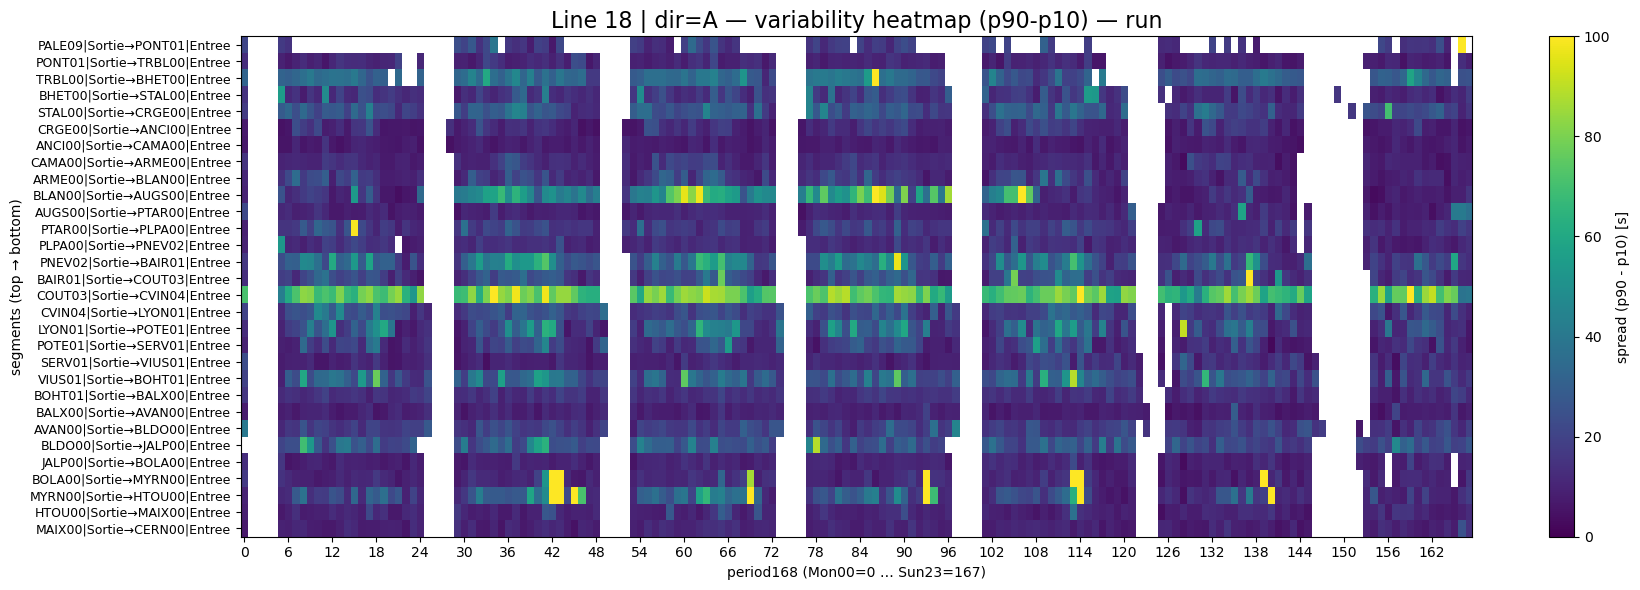

In [138]:
# 3B) Variability heatmap (p90-p10)
plot_heatmap_spread_win(W_oct, ordered_run, line=18, dir_="A",
                        type_filter="run", min_n=10, vmax=100)


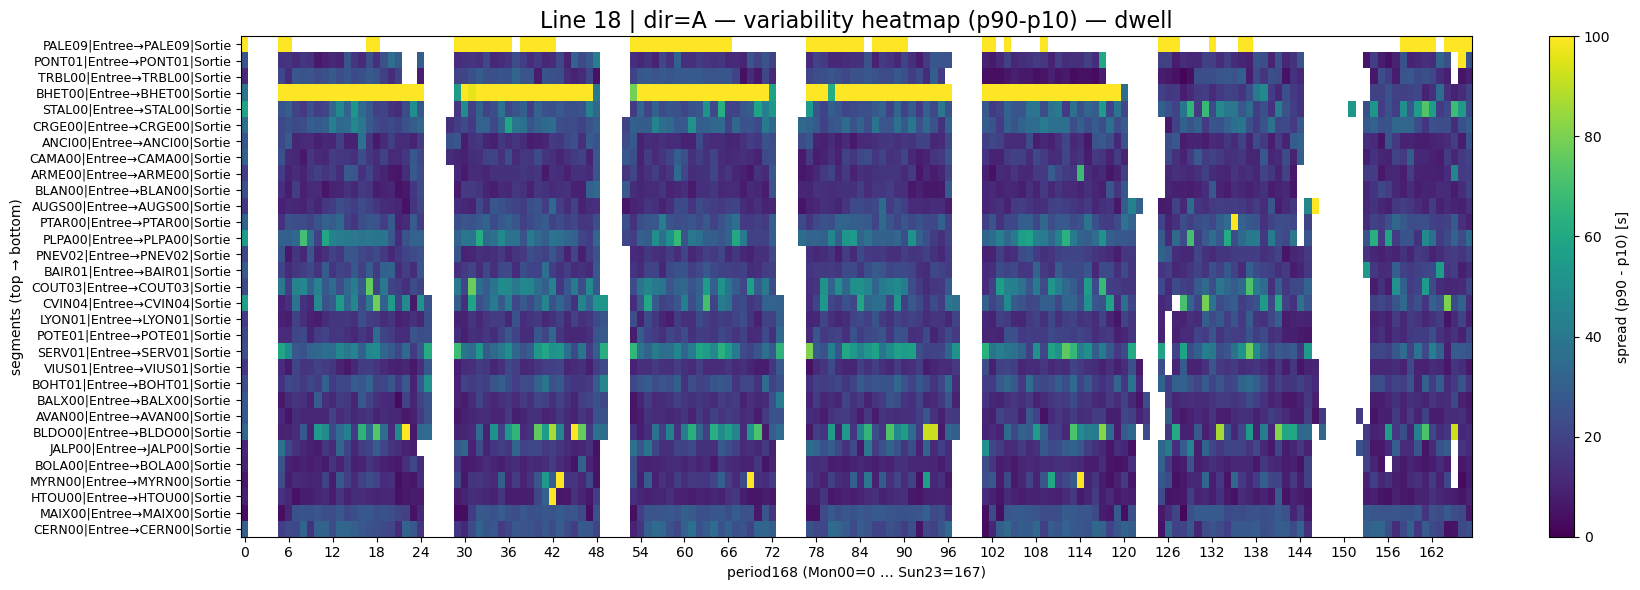

In [144]:
plot_heatmap_spread_win(W_oct, ordered_dwel, line=18, dir_="A",
                        type_filter="dwell", min_n=10, vmax=100)

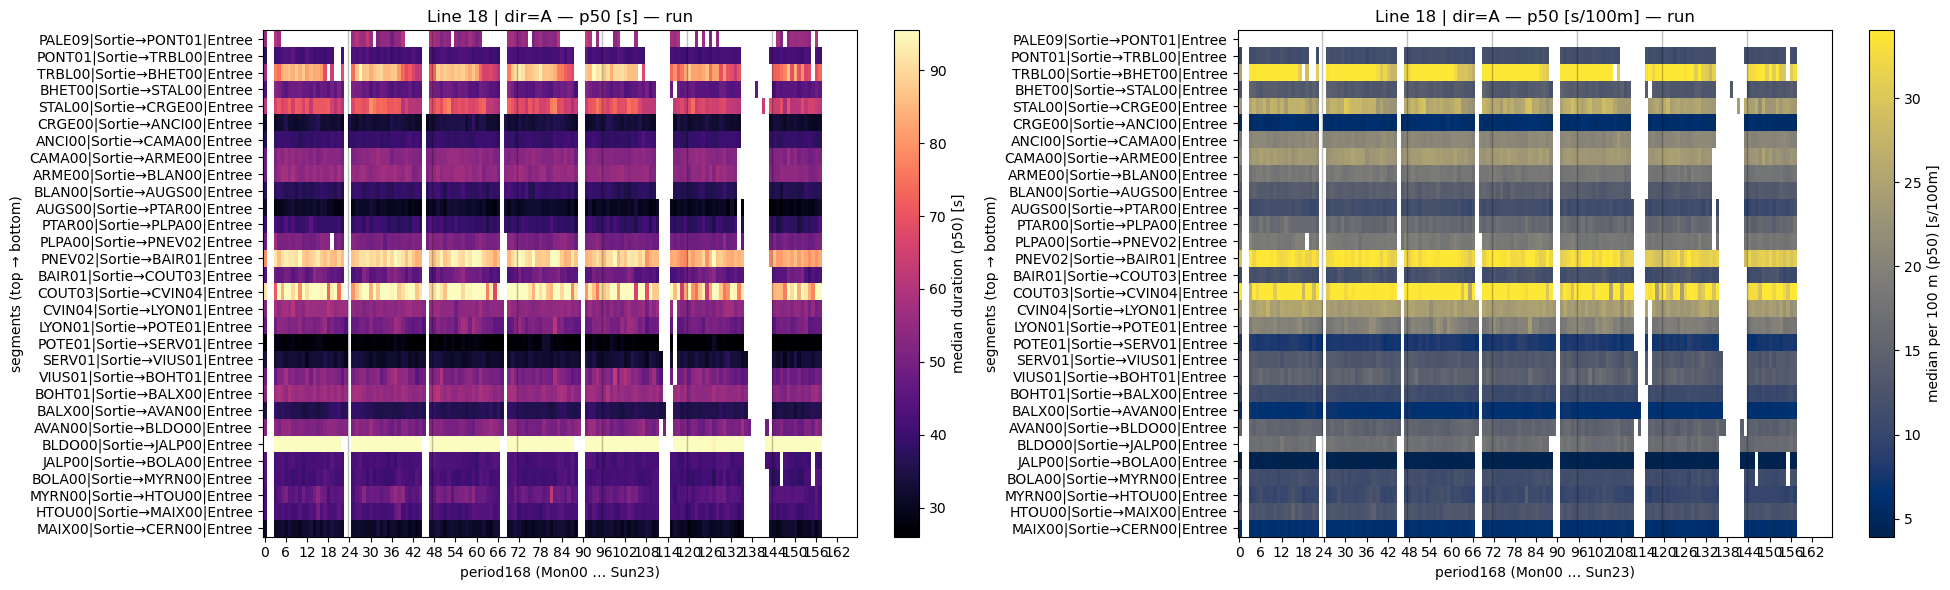

In [155]:
# 3C) p50 heatmap (and per-distance)
plot_p50_heatmap_with_distance_win(W_oct, ordered_run, line=18, dir_="A",
                                   type_filter="run", min_n=10, norm_unit_m=100,
                                   show_raw=True, show_norm=True,
                                   cmap_raw="magma", cmap_norm="cividis", figsize=(20,6))